#Implementing Random Forest and GBT Models to predict the price of Diamonds 

This will prove that diamonds are forever.  In on our previous exploration of the diamonds df. In where we used linear regression to predict diamond prices and evaluated model performance using MSE as the scoring metric.  In this homework, we are going to use the same diamonds data set but this time use decision trees and deep learning to see if we can improve upon the linear regression performance.

# Diamonds Data
Just to prove that diamonds are forever, we are going to revisit the diamonds data set.  This exercise uses the diamonds dataset to explore random forest decision tree models.

The diamonds.csv data set contains 10 columns:
- carat: Carat weight of the diamond
- cut: Describes cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal
- color: Color of the diamond, with D being the best and J the worst
- clarity: How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, etc.  See this web site for an exhaustive ranking of [clarity](https://4cs.gia.edu/en-us/diamond-clarity/?gclid=Cj0KCQjwnqH7BRDdARIsACTSAduMoc2KQbXkO94BxCfBNC5X8YyjAYcFpWThKQMW46cQj_3p0pZ0o84aAuagEALw_wcB).  The web site has a nice sliding scale you can drag to see the relationship between clarity grades.
- depth: depth % - The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
- table: table% -  The width of the diamond's table expressed as a percentage of its average diameter
- price: The price of the diamond
- x: Length (mm)
- y: Width (mm)
- z: Height (mm)

In [ ]:
# Grading Cell
enable_grid_search = False

In [ ]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./quotes_by_char.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/diamonds.csv  
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=52fa0b950a3dbd542d7ecee3db0f67cd6d54a3bcf0b71f1ee3c2af501dd8f99b
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-24 02:57:08--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/diamonds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3192560 (3.0M) [text/plain]
Saving to: ‘diamonds.csv’

     0K .......... .......... .......... .......... ..........  1% 37.1M 0s
    50K .......... .......... .......... .......... ..........  3% 32.4M 0s
   100K .......... .......... .......... .......... ..........  4% 71.8M 0s
   150K .......... .......... .......... .......... ..........  6% 39.7M 0s
   200K .......... .......... .......... .......... ..........  8% 49.7M 0s
   250K .......... .......... .......... .......... ..........  9% 70.7M 0s
   300K .......... .......... .......... .......... .......... 11% 71.1M 0s
   350K .......... .......... ........

#Reading in the Diamonds Dataframe
Read the diamonds.csv file into a spark data frame named `diamonds_df`.  Perform feature engineering as needed for training decision trees.  Name the new data frame diamonds_df_xformed.

In [ ]:
# your code here
# Your code here
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
# import statements
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#spark = SparkSession.builder.getOrCreate()
#here, we modify the configuration of our spark context by changing the maxresult size, off heap, driver and executor memory to 12 gigabytes
#almost all problems within this notebook were solved by modifying these configuration settings
spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction", 0.9) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .config("spark.driver.maxResultSize", "12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os
diamonds_df = spark.read.format("csv").option("header", "true").load('diamonds.csv')
diamonds_df = diamonds_df.drop('_c0')

diamonds_df = diamonds_df.selectExpr("cast(carat as float) carat",
     "cast(depth as float) depth",
     "cast(table as float) table",
     "cast(x as float) x",
      "cast(y as float) y",
      "cast(z as float) z",
      "cast(price as float) price",
      "cast(cut as string) cut",
      "cast(color as string) color",
      "cast(clarity as string) clarity")                                              
diamonds_df.printSchema()
diamonds_df.show(truncate=False)

root
 |-- carat: float (nullable = true)
 |-- depth: float (nullable = true)
 |-- table: float (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- z: float (nullable = true)
 |-- price: float (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)

+-----+-----+-----+----+----+----+-----+---------+-----+-------+
|carat|depth|table|x   |y   |z   |price|cut      |color|clarity|
+-----+-----+-----+----+----+----+-----+---------+-----+-------+
|0.23 |61.5 |55.0 |3.95|3.98|2.43|326.0|Ideal    |E    |SI2    |
|0.21 |59.8 |61.0 |3.89|3.84|2.31|326.0|Premium  |E    |SI1    |
|0.23 |56.9 |65.0 |4.05|4.07|2.31|327.0|Good     |E    |VS1    |
|0.29 |62.4 |58.0 |4.2 |4.23|2.63|334.0|Premium  |I    |VS2    |
|0.31 |63.3 |58.0 |4.34|4.35|2.75|335.0|Good     |J    |SI2    |
|0.24 |62.8 |57.0 |3.94|3.96|2.48|336.0|Very Good|J    |VVS2   |
|0.24 |62.3 |57.0 |3.95|3.98|2.47|336.0|Very Good|I    |VV

In [ ]:
#dropping rows where any of the dimensional values correspond to 0. This must be an error resulting from the data collection process. 
diamonds_df=diamonds_df.where("x!=0")
diamonds_df=diamonds_df.where("z!=0")
diamonds_df=diamonds_df.where("y!=0")

diamonds_df.describe().show()

+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+---------+-----+-------+
|summary|              carat|             depth|            table|                 x|                 y|                 z|            price|      cut|color|clarity|
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+---------+-----+-------+
|  count|              53920|             53920|            53920|             53920|             53920|             53920|            53920|    53920|53920|  53920|
|   mean| 0.7976982547517435| 61.74951409105024|57.45683419916679| 5.731626855743391| 5.734887055937721|3.5400463788153864|3930.993230712166|     null| null|   null|
| stddev|0.47379529081885396|1.4323310767813764|2.234064210082644|1.1194228227212342|1.1401257946400718|0.7025303402115977|3987.280445975295|     null| null|   null|
|   

In [ ]:
# your code her
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexerModel, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import when, col
#ordering cut from worst to best
diamonds_df_xformed = diamonds_df
#using stringindexermodel to manually order our categorical variables according to their respective ranks
cu = StringIndexerModel.from_labels(['Fair','Good','Very Good','Premium','Ideal'], inputCol="cut",outputCol="ordered_cut")
co = StringIndexerModel.from_labels(['J','I','H','G','F','E','D'], inputCol="color",outputCol="ordered_color")
cl = StringIndexerModel.from_labels(['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'], inputCol ="clarity",outputCol = "ordered_clarity")
#creating our feature engineering pipeline that will add each of these attributes and then fit them on the rest of our dataframe
feature_engineering_pipe = Pipeline(stages=[cu,co,cl])
#model = feature_engineering_pipe.fit(diamonds_df_xformed)
#fit transforming this pipeline on data frame and dropping original string formatted categorical attributes
diamonds_df_xformed = feature_engineering_pipe.fit(diamonds_df_xformed).transform(diamonds_df_xformed)
diamonds_df_xformed=diamonds_df_xformed.drop('cut','color','clarity')

In [ ]:
#renaming these variables so our new dataframe will have the same column names as the original
diamonds_df_xformed= diamonds_df_xformed.withColumnRenamed('ordered_cut','cut')
diamonds_df_xformed= diamonds_df_xformed.withColumnRenamed('ordered_color','color')
diamonds_df_xformed= diamonds_df_xformed.withColumnRenamed('ordered_clarity','clarity')

In [ ]:
#viewing distributions of columns in diamonds datarame
df = diamonds_df_xformed.toPandas()
import seaborn as sns
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr = df.corr()

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\

,carat,depth,table,x,y,z,price,cut,color,clarity
carat,1.000000,0.028259,0.181646,0.977779,0.953991,0.961048,0.921592,-0.134953,-0.291360,-0.352757
depth,0.028259,1.000000,-0.295733,-0.025017,-0.029069,0.095023,-0.010729,-0.218073,-0.047373,-0.067457
table,0.181646,-0.295733,1.000000,0.196097,0.184493,0.152483,0.127245,-0.433306,-0.026481,-0.160256
x,0.977779,-0.025017,0.196097,1.000000,0.974918,0.975435,0.887231,-0.126232,-0.270671,-0.372865
y,0.953991,-0.029069,0.184493,0.974918,1.000000,0.956744,0.867864,-0.122181,-0.263915,-0.359015
z,0.961048,0.095023,0.152483,0.975435,0.956744,1.000000,0.868206,-0.150647,-0.270011,-0.370250
price,0.921592,-0.010729,0.127245,0.887231,0.867864,0.868206,1.000000,-0.053491,-0.172431,-0.146789
cut,-0.134953,-0.218073,-0.433306,-0.126232,-0.122181,-0.150647,-0.053491,1.000000,0.020517,0.189153
color,-0.291360,-0.047373,-0.026481,-0.270671,-0.263915,-0.270011,-0.172431,0.020517,1.000000,-0.025783
clarity,-0.352757,-0.067457,-0.160256,-0.372865,-0.359015,-0.370250,-0.146789,0.189153,-0.025783,1.000000


In [ ]:
#carat is the most strongly correlated with price followed by x, y and z respectively. Depth is the least correlated, followed by cut, clarity, color, and table 
import plotly.express as px
for col in df.columns:
  fig = px.histogram(df, x = col)
  #fig.show()

In [ ]:
#preprocessed diamonds df
diamonds_df_xformed.show()

+-----+-----+-----+----+----+----+-----+---+-----+-------+
|carat|depth|table|   x|   y|   z|price|cut|color|clarity|
+-----+-----+-----+----+----+----+-----+---+-----+-------+
| 0.23| 61.5| 55.0|3.95|3.98|2.43|326.0|4.0|  5.0|    1.0|
| 0.21| 59.8| 61.0|3.89|3.84|2.31|326.0|3.0|  5.0|    2.0|
| 0.23| 56.9| 65.0|4.05|4.07|2.31|327.0|1.0|  5.0|    4.0|
| 0.29| 62.4| 58.0| 4.2|4.23|2.63|334.0|3.0|  1.0|    3.0|
| 0.31| 63.3| 58.0|4.34|4.35|2.75|335.0|1.0|  0.0|    1.0|
| 0.24| 62.8| 57.0|3.94|3.96|2.48|336.0|2.0|  0.0|    5.0|
| 0.24| 62.3| 57.0|3.95|3.98|2.47|336.0|2.0|  1.0|    6.0|
| 0.26| 61.9| 55.0|4.07|4.11|2.53|337.0|2.0|  2.0|    2.0|
| 0.22| 65.1| 61.0|3.87|3.78|2.49|337.0|0.0|  5.0|    3.0|
| 0.23| 59.4| 61.0| 4.0|4.05|2.39|338.0|2.0|  2.0|    4.0|
|  0.3| 64.0| 55.0|4.25|4.28|2.73|339.0|1.0|  0.0|    2.0|
| 0.23| 62.8| 56.0|3.93| 3.9|2.46|340.0|4.0|  0.0|    4.0|
| 0.22| 60.4| 61.0|3.88|3.84|2.33|342.0|3.0|  4.0|    2.0|
| 0.31| 62.2| 54.0|4.35|4.37|2.71|344.0|4.0|  0.0|    1.

In [ ]:
display(diamonds_df_xformed.toPandas().head())

,carat,depth,table,x,y,z,price,cut,color,clarity
0,0.23,61.500000,55.0,3.95,3.98,2.43,326.0,4.0,5.0,1.0
1,0.21,59.799999,61.0,3.89,3.84,2.31,326.0,3.0,5.0,2.0
2,0.23,56.900002,65.0,4.05,4.07,2.31,327.0,1.0,5.0,4.0
3,0.29,62.400002,58.0,4.20,4.23,2.63,334.0,3.0,1.0,3.0
4,0.31,63.299999,58.0,4.34,4.35,2.75,335.0,1.0,0.0,1.0


The following section will create a random forest regressor model, train the model using a grid search, and use the model for inference.  The goal is to see if we can improve upon the linear regression score from homework 3. You can find the spark documentation for the random forest regressor [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-regression).

# Training our Random Forest Regressor Model
Create and train your random forest regressor model using a grid search in the cell below.  You are free to use K-Fold Cross validation if you wish.  Your grid search must be entirely encapsulated in the `if enable_grid_search` if statement.  The `enable_grid_search` Boolean is defined in a grading cell above.  You will disable the grid search before you submit by setting enable_grid_search to false.  Setting enable_grid_search to false should not result in a runtime error.  You will not receive full credit if any part of your grid search is outside of the if statement or if runtime errros result from setting the `enable_grid_search` variable to false.

In [ ]:
#reference linear regression
#Mean Squared Error of Cross Validated Model on Training Data:  1269654.66
#Mean Squared Error of Cross Validated Model on Testing Data:  1274108.05
#Cross validation average MSE: 1307177.4434235378
#Mean Squared Error of Linear Regression model after being scaled via Standard Scaler:  1450841.11

In [ ]:
# your code here
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
# Next, we utilize a VectorAssembler that combines a list of columns into a single vector column to convert all the independent variables into a single features vector. This is the only input spark can handle for Machine Learning models in the case of Linear Regression. 
# list of numeric variables
numeric_vars = ['carat', 'depth', 'table', 'x', 'y', 'z']
#categorical variables + numeric variables = features.
cat_cols = ['cut','color','clarity']
assembler_input =  cat_cols + numeric_vars  #ind_cols
assembler = VectorAssembler(inputCols=assembler_input, outputCol="features")
from pyspark.ml import feature, regression, evaluation, Pipeline
#splitting our data so that 70% of it will be used for training our model, while the remaining 30% will be used to test our model
training_df, testing_df = diamonds_df_xformed.randomSplit([0.7, 0.3])
# Load and parse the data file, converting it to a DataFrame.
# Split the data into training and test sets (30% held out for testing)
# Train a RandomForest model.
rf = RandomForestRegressor(labelCol = 'price',featuresCol="features")
# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[assembler, rf])
# Train model.  This also runs the indexer.
model = pipeline.fit(training_df)
# Make predictions.
predictions = model.transform(testing_df)
# Select example rows to display.

In [ ]:
import pyspark.sql.functions as func
df_pred = predictions.withColumn("predictions", func.round(predictions["prediction"], 2)).withColumnRenamed("prediction","pred")
df_pred.select("predictions", "price", "features").show(10)

+-----------+-----+--------------------+
|predictions|price|            features|
+-----------+-----+--------------------+
|     664.28|367.0|[4.0,5.0,3.0,0.20...|
|     662.65|367.0|[3.0,5.0,3.0,0.20...|
|     662.65|367.0|[3.0,5.0,3.0,0.20...|
|     656.49|345.0|[3.0,5.0,1.0,0.20...|
|     662.65|367.0|[3.0,6.0,3.0,0.20...|
|     664.28|367.0|[4.0,5.0,3.0,0.20...|
|     662.65|367.0|[3.0,6.0,3.0,0.20...|
|     662.65|404.0|[3.0,5.0,3.0,0.21...|
|     673.43|498.0|[1.0,5.0,6.0,0.23...|
|     662.65|411.0|[3.0,6.0,3.0,0.23...|
+-----------+-----+--------------------+
only showing top 10 rows



In [ ]:
#importing the necessary packages for our correlation map
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)
correlation_matrix(diamonds_df_xformed,diamonds_df.columns, method='pearson')

,carat,depth,table,x,y,z,price,cut,color,clarity
carat,1.000000,0.028259,0.181646,0.977779,0.953991,0.961048,0.921592,-0.134953,-0.291360,-0.352757
depth,0.028259,1.000000,-0.295733,-0.025017,-0.029069,0.095023,-0.010729,-0.218073,-0.047373,-0.067457
table,0.181646,-0.295733,1.000000,0.196097,0.184493,0.152483,0.127245,-0.433306,-0.026481,-0.160256
x,0.977779,-0.025017,0.196097,1.000000,0.974918,0.975435,0.887231,-0.126232,-0.270671,-0.372865
y,0.953991,-0.029069,0.184493,0.974918,1.000000,0.956744,0.867864,-0.122181,-0.263915,-0.359015
z,0.961048,0.095023,0.152483,0.975435,0.956744,1.000000,0.868206,-0.150647,-0.270011,-0.370250
price,0.921592,-0.010729,0.127245,0.887231,0.867864,0.868206,1.000000,-0.053491,-0.172431,-0.146789
cut,-0.134953,-0.218073,-0.433306,-0.126232,-0.122181,-0.150647,-0.053491,1.000000,0.020517,0.189153
color,-0.291360,-0.047373,-0.026481,-0.270671,-0.263915,-0.270011,-0.172431,0.020517,1.000000,-0.025783
clarity,-0.352757,-0.067457,-0.160256,-0.372865,-0.359015,-0.370250,-0.146789,0.189153,-0.025783,1.000000


In [ ]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Random Forest Mean Squared Error (MSE) on Test data before tuning = %g" % mse)
print("Average Cross Validate MSE of Linear Regressor Model from Homework 3 = 1307177.4")
rfModel = model.stages[1]
print(rfModel) 

Random Forest Mean Squared Error (MSE) on Test data before tuning = 1.04125e+06
Average Cross Validate MSE of Linear Regressor Model from Homework 3 = 1307177.4
RandomForestRegressionModel: uid=RandomForestRegressor_eb3703191c7d, numTrees=20, numFeatures=9


In [ ]:
#feature importance of our initial random forest model before tuning 
import pandas as pd
pd.DataFrame(list(zip(assembler_input, rfModel.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)


,column,weight
3,carat,0.324843
7,y,0.278478
6,x,0.223354
8,z,0.128269
2,clarity,0.031038
1,color,0.011157
5,table,0.001240
0,cut,0.000882
4,depth,0.000739


#####These weights certainly correspond to the relative correlation values of each column to price. Carat is more strongly correlated to price than y in our correlation map but it is certainly close following this method suggesting no red flags in our process thus far

In [ ]:
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#creating our rf regression as a step in one of our pipeline's stages. Price would correspond to the models label in this case
pipeline1 = Pipeline(stages=[assembler, rf])
#gridsearch parameters for tuning our model
if enable_grid_search:

  eval = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
  param_grid = ParamGridBuilder() \
  .addGrid(rf.numTrees, range(5,75,5)) \
  .addGrid(rf.maxDepth, range(5,15,5)) \
  .build() 
  crossval = CrossValidator(estimator=pipeline1,
                            estimatorParamMaps=param_grid,
                            evaluator=eval,
                            numFolds=3)
  cvmodel = crossval.fit(training_df)
  predictions = cvmodel.transform(testing_df)
  mse = eval.evaluate(predictions)
  rfPred = cvmodel.transform(diamonds_df_xformed)
#  rfResult = rfPred.toPandas()
  # import matplotlib.pyplot as plt
  # plt.plot(rfResult.price, rfResult.prediction, 'bo')
  # plt.xlabel('Price')
  # plt.ylabel('Prediction')
  # plt.suptitle("Model Performance MSE on entire diamonds dataframe: %f" % mse)
  # plt.show()
  rf_model = cvmodel.bestModel.stages[1] 
  # var_imp = rf_model.featureImportances
  # #feature importance of our initial random forest model before tuning 
  # import pandas as pd
  # pd.DataFrame(list(zip(assembler_input, var_imp.toArray())),
  #           columns = ['column', 'weight']).sort_values('weight',ascending=False)
  # cvmodel.bestModel.stages[-1].extractParamMap()
  print("RF:",cvmodel.bestModel.stages[-1])
  # Select (prediction, true label) and compute test error
  evaluator = RegressionEvaluator(
      labelCol="price", predictionCol="prediction", metricName="mse")
  mse_new = evaluator.evaluate(rfPred)
  mse = evaluator.evaluate(predictions)
  print("Mean Squared Error (MSE) of Random Forest Model before tuning = %g" % mse)
  print("Mean Squared Error (MSE) of Best Random Forest Model after Tuning= %g" % mse_new)
  diff = mse - mse_new
  print("RF Model MSE Improvement = %g" % diff)
  print("Average Cross Validate MSE of Linear Regressor Model from Homework 3 = 1307177.4")
  from pyspark.ml.regression import RandomForestRegressionModel
  RandomForestRegressor.getMaxDepth = (lambda self: self._java_obj.getMaxDepth())
  print("Best CV Model Max Depth:", cvmodel.bestModel.stages[-1].getMaxDepth())
  print("Best Number of Trees from Tuned CV Model:", 45)
  pass

# K-Fold Cross Validation to Optimize our Pipeline
Create a pipeline named `best_pipe` that hard codes the tuning parameters from the best model found by the grid search in the previous section.  Train and test best_pipe. Clearly print the resulting train and test MSE for best_pipe so it's easy for the graders to see your resulting MSEs.

In [ ]:
# Your code here
rf = RandomForestRegressor(labelCol = 'price',featuresCol="features",numTrees=45,maxDepth=10)
# Chain indexer and forest in a Pipeline
best_pipe = Pipeline(stages=[assembler, rf])
# Train model.  This also runs the indexer.
best_model = best_pipe.fit(training_df)
# Make predictions.
predictions_test = best_model.transform(testing_df)
predictions_train = best_model.transform(training_df)
# Select example rows to display.
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="mse")
mse_test = evaluator.evaluate(predictions_test)
mse_tr = evaluator.evaluate(predictions_train)
diff_mse = mse_test - mse_tr
print("Mean Squared Error (MSE) of Best Random Forest Model on Testing Data after Tuning= %g" % mse_test)
print("Mean Squared Error (MSE) of Best Random Forest Model on Training Data after Tuning= %g" % mse_tr)
print("RF Difference between testing and training MSE = %g" % diff_mse)

Mean Squared Error (MSE) of Best Random Forest Model on Testing Data after Tuning= 437555
Mean Squared Error (MSE) of Best Random Forest Model on Training Data after Tuning= 350905
RF Difference between testing and training MSE = 86649.9


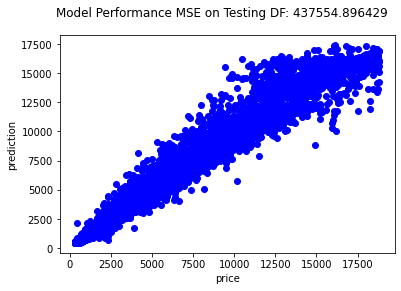

In [ ]:
  #using pandas to plot Price vs. Prediction
  pred_test = predictions_test.toPandas()
  # cvmodel = crossval.fit(training_df)
  # predictions = cvmodel.transform(testing_df)
  # mse = eval.evaluate(predictions)
  # rfPred = cvmodel.transform(diamonds_df_xformed)
  # rfResult = rfPred.toPandas()
  import matplotlib.pyplot as plt
  plt.plot(pred_test.price, pred_test.prediction, 'bo')
  plt.xlabel('price')
  plt.ylabel('prediction')
  plt.suptitle("Model Performance MSE on Testing DF: %f" % mse_test)
  plt.show()
  # rf_model = cvmodel.bestModel.stages[1] 
  # var_imp = rf_model.featureImportances
  # #feature importance of our initial random forest model before tuning 
  # import pandas as pd
  # pd.DataFrame(list(zip(assembler_input, var_imp.toArray())),
  #           columns = ['column', 'weight']).sort_values('weight',ascending=False)

The Model is overfitting on the training data but still saw a drastic reduction in MSE compared to our untuned model. It also performs  
much better than our linear regressor model for predicting price, seen in Homework 3 (reference MSE of 1307177). The MSE of our RF model on testing data was 449674 while the error on training data was 348177 which is a discrepancy of over 100k units. We will work on ensuring that future models in this experiment aren't as prone to overfitting by closely working with and tuning model hyperparameters.

#Feature Importance of our Best Random Forest Pipeline
Use your best_pipe pipeline in question 3 for inference.  Create a pandas data frame named `rf_feature_importance` which contains 2 columns: `feature`, and `importance`.  Load the feature column with the feature name and the importance column with the feature importance score as determined by the random forest model. Sort the feature importances from high to low such that the most important feature is in the first row of the data frame.

In [ ]:
# your code here
var_imp = best_model.stages[-1].featureImportances
#feature importance of our initial random forest model before tuning 
import pandas as pd
rf_feature_importance = pd.DataFrame(list(zip(assembler_input, var_imp.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5, 1.0, 'Feature Importances')

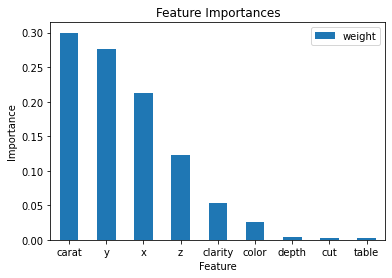

In [ ]:
#plotting our feature importances for best random forest model
importances = best_model.stages[-1].featureImportances
ax = rf_feature_importance.plot.bar(x='column', y='weight', rot=0)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [ ]:
display(rf_feature_importance)

,column,weight
3,carat,0.299830
7,y,0.276259
6,x,0.211871
8,z,0.122817
2,clarity,0.053283
1,color,0.026490
4,depth,0.003335
0,cut,0.003181
5,table,0.002934


# Decision Logic for Tree in the Forest following pipeline optimization
Write code to print the decision logic for any of the trees in the forest from the best_pipe pipeline.  Copy the printed decision text to the tree printout markdown cell below and retain the same formatting and indentation as the code printout so it's easy for the graders to view the data.  You need to double click the "Your Decision Tree Print Out Here" markdown cell and paste your output inside the two sets of triple quotes. The triple quotes are jupyter markdown indicating you want to present code.  Essentially, replace the text inside the triple quotes with your tree printout.  Solutions that do not maintain readable formatting will not receive full credit.

Add comments to the markdown cell below describing how the root node is split:  Describe 2 things in the markdown cell.  1) What specific predictor variable is being split and what is the value that determines the left / right split.  2) We need you to paste the tree decision logic output from your run in the markdown cell because the top level split may change from run to run.  If the graders run your notebook, the top level split for the tree may be different than the top level split from when you made the run.  Describe why the top level predictor changes from run to run.


In [ ]:
#showing dataframe for understanding feature references for logical decision boundaries
diamonds_df_xformed.show()

+-----+-----+-----+----+----+----+-----+---+-----+-------+
|carat|depth|table|   x|   y|   z|price|cut|color|clarity|
+-----+-----+-----+----+----+----+-----+---+-----+-------+
| 0.23| 61.5| 55.0|3.95|3.98|2.43|326.0|4.0|  5.0|    1.0|
| 0.21| 59.8| 61.0|3.89|3.84|2.31|326.0|3.0|  5.0|    2.0|
| 0.23| 56.9| 65.0|4.05|4.07|2.31|327.0|1.0|  5.0|    4.0|
| 0.29| 62.4| 58.0| 4.2|4.23|2.63|334.0|3.0|  1.0|    3.0|
| 0.31| 63.3| 58.0|4.34|4.35|2.75|335.0|1.0|  0.0|    1.0|
| 0.24| 62.8| 57.0|3.94|3.96|2.48|336.0|2.0|  0.0|    5.0|
| 0.24| 62.3| 57.0|3.95|3.98|2.47|336.0|2.0|  1.0|    6.0|
| 0.26| 61.9| 55.0|4.07|4.11|2.53|337.0|2.0|  2.0|    2.0|
| 0.22| 65.1| 61.0|3.87|3.78|2.49|337.0|0.0|  5.0|    3.0|
| 0.23| 59.4| 61.0| 4.0|4.05|2.39|338.0|2.0|  2.0|    4.0|
|  0.3| 64.0| 55.0|4.25|4.28|2.73|339.0|1.0|  0.0|    2.0|
| 0.23| 62.8| 56.0|3.93| 3.9|2.46|340.0|4.0|  0.0|    4.0|
| 0.22| 60.4| 61.0|3.88|3.84|2.33|342.0|3.0|  4.0|    2.0|
| 0.31| 62.2| 54.0|4.35|4.37|2.71|344.0|4.0|  0.0|    1.

In [ ]:
# your code here
rff = best_model.stages[-1].trees[0].toDebugString
print(rff)

DecisionTreeRegressionModel: uid=dtr_6264ddb633b3, depth=10, numNodes=1675, numFeatures=9
  If (feature 7 <= 6.375)
   If (feature 4 <= 62.64999961853027)
    If (feature 8 <= 3.3850001096725464)
     If (feature 7 <= 5.065000057220459)
      If (feature 7 <= 4.625)
       If (feature 6 <= 4.305000066757202)
        If (feature 2 in {1.0,2.0,3.0,4.0})
         If (feature 1 in {0.0,1.0,2.0,3.0,4.0})
          If (feature 2 in {1.0,2.0})
           If (feature 0 in {2.0,3.0,4.0})
            Predict: 437.56716417910445
           Else (feature 0 not in {2.0,3.0,4.0})
            Predict: 1013.0
          Else (feature 2 not in {1.0,2.0})
           If (feature 3 <= 0.29500000178813934)
            Predict: 461.03636363636366
           Else (feature 3 > 0.29500000178813934)
            Predict: 548.022346368715
         Else (feature 1 not in {0.0,1.0,2.0,3.0,4.0})
          If (feature 4 <= 60.85000038146973)
           If (feature 6 <= 4.244999885559082)
            Predict: 430.5
   

 ```
Your Decision Tree Print Out Here - Replace this text with the tree decision logic: DecisionTreeRegressionModel: uid=dtr_1f71a55246f4, depth=10, numNodes=1693, numFeatures=9
  If (feature 6 <= 6.325000047683716)
   If (feature 8 <= 3.415000081062317)
    If (feature 3 <= 0.4350000023841858)
     If (feature 3 <= 0.375)
      If (feature 0 in {1.0,2.0})
       If (feature 3 <= 0.29500000178813934)
        If (feature 2 in {3.0,4.0})
         If (feature 5 <= 59.04999923706055)
          If (feature 6 <= 4.244999885559082)
           If (feature 4 <= 62.04999923706055)
            Predict: 426.47058823529414
           Else (feature 4 > 62.04999923706055)
            Predict: 444.1186440677966
          Else (feature 6 > 4.244999885559082)
           If (feature 4 <= 59.85000038146973)
            Predict: 488.25
           Else (feature 4 > 59.85000038146973)
            Predict: 568.5
         Else (feature 5 > 59.04999923706055)
          If (feature 6 <= 4.244999885559082)
           If (feature 1 in {2.0})
            Predict: 338.0
           Else (feature 1 not in {2.0})
            Predict: 387.7916666666667
          Else (feature 6 > 4.244999885559082)
           Predict: 452.0
        Else (feature 2 not in {3.0,4.0})
         If (feature 1 in {0.0,1.0,2.0,3.0})
          If (feature 7 <= 4.255000114440918)
           If (feature 1 in {0.0,1.0})
            Predict: 382.14285714285717
           Else (feature 1 not in {0.0,1.0})
            Predict: 465.85714285714283
          Else (feature 7 > 4.255000114440918)
           If (feature 1 in {2.0})
            Predict: 499.0
           Else (feature 1 not in {2.0})
            Predict: 565.6363636363636
         Else (feature 1 not in {0.0,1.0,2.0,3.0})
          If (feature 6 <= 4.244999885559082)
           If (feature 5 <= 59.04999923706055)
            Predict: 562.402390438247
           Else (feature 5 > 59.04999923706055)
            Predict: 521.7654320987655
          Else (feature 6 > 4.244999885559082)
           If (feature 4 <= 60.64999961853027)
            Predict: 695.5625
           Else (feature 4 > 60.64999961853027)
            Predict: 630.4
       Else (feature 3 > 0.29500000178813934)
        If (feature 6 <= 4.434999942779541)
         If (feature 1 in {0.0,1.0,2.0})
          If (feature 7 <= 4.255000114440918)
           If (feature 2 in {1.0,2.0,3.0,4.0})
            Predict: 515.2592592592592
           Else (feature 2 not in {1.0,2.0,3.0,4.0})
            Predict: 761.2666666666667
          Else (feature 7 > 4.255000114440918)
           If (feature 5 <= 61.20000076293945)
            Predict: 531.2131661442006
           Else (feature 5 > 61.20000076293945)
            Predict: 443.5
         Else (feature 1 not in {0.0,1.0,2.0})
          If (feature 0 in {1.0})
           If (feature 2 in {0.0,1.0,2.0,3.0})
            Predict: 556.4191176470588
           Else (feature 2 not in {0.0,1.0,2.0,3.0})
            Predict: 720.1276595744681
          Else (feature 0 not in {1.0})
           If (feature 2 in {1.0,2.0,3.0,4.0})
            Predict: 600.0588235294117
           Else (feature 2 not in {1.0,2.0,3.0,4.0})
            Predict: 820.4861878453039
        Else (feature 6 > 4.434999942779541)
         If (feature 2 in {1.0,2.0,3.0})
          If (feature 6 <= 4.505000114440918)
           If (feature 2 in {1.0})
            Predict: 493.4375
           Else (feature 2 not in {1.0})
            Predict: 585.4814814814815
          Else (feature 6 > 4.505000114440918)
           If (feature 1 in {0.0,1.0,3.0})
            Predict: 522.9310344827586
           Else (feature 1 not in {0.0,1.0,3.0})
            Predict: 648.175925925926
         Else (feature 2 not in {1.0,2.0,3.0})
          If (feature 2 in {4.0,5.0})
           If (feature 8 <= 2.774999976158142)
            Predict: 707.8421052631579
           Else (feature 8 > 2.774999976158142)
            Predict: 778.6785714285714
          Else (feature 2 not in {4.0,5.0})
           If (feature 1 in {0.0,1.0,2.0})
            Predict: 767.7894736842105
           Else (feature 1 not in {0.0,1.0,2.0})
            Predict: 970.8837209302326
      Else (feature 0 not in {1.0,2.0})
       If (feature 3 <= 0.29500000178813934)
        If (feature 7 <= 4.255000114440918)
         If (feature 6 <= 4.244999885559082)
          If (feature 1 in {0.0,1.0,2.0,3.0})
           If (feature 0 in {4.0})
            Predict: 499.10843373493975
           Else (feature 0 not in {4.0})
            Predict: 548.421052631579
          Else (feature 1 not in {0.0,1.0,2.0,3.0})
           If (feature 2 in {2.0,3.0,4.0})
            Predict: 513.5263157894736
           Else (feature 2 not in {2.0,3.0,4.0})
            Predict: 678.1485714285715
         Else (feature 6 > 4.244999885559082)
          If (feature 4 <= 58.75)
           Predict: 1013.0
          Else (feature 4 > 58.75)
           If (feature 2 in {2.0,3.0,4.0})
            Predict: 553.2857142857143
           Else (feature 2 not in {2.0,3.0,4.0})
            Predict: 646.0
        Else (feature 7 > 4.255000114440918)
         If (feature 1 in {2.0,3.0})
          If (feature 1 in {3.0})
           If (feature 5 <= 54.04999923706055)
            Predict: 503.2857142857143
           Else (feature 5 > 54.04999923706055)
            Predict: 618.0
          Else (feature 1 not in {3.0})
           If (feature 2 in {4.0})
            Predict: 498.0
           Else (feature 2 not in {4.0})
            Predict: 607.0
         Else (feature 1 not in {2.0,3.0})
          If (feature 5 <= 55.04999923706055)
           If (feature 6 <= 4.305000066757202)
            Predict: 780.5
           Else (feature 6 > 4.305000066757202)
            Predict: 619.0
          Else (feature 5 > 55.04999923706055)
           If (feature 4 <= 60.45000076293945)
            Predict: 591.0
           Else (feature 4 > 60.45000076293945)
            Predict: 695.8333333333334
       Else (feature 3 > 0.29500000178813934)
        If (feature 6 <= 4.434999942779541)
         If (feature 4 <= 61.95000076293945)
          If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
           If (feature 2 in {0.0,1.0,2.0})
            Predict: 542.3185595567867
           Else (feature 2 not in {0.0,1.0,2.0})
            Predict: 699.8266978922717
          Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
           If (feature 1 in {0.0,1.0,2.0})
            Predict: 712.9035532994924
           Else (feature 1 not in {0.0,1.0,2.0})
            Predict: 892.0134048257372
         Else (feature 4 > 61.95000076293945)
          If (feature 1 in {0.0,1.0})
           If (feature 3 <= 0.3149999976158142)
            Predict: 519.1512605042017
           Else (feature 3 > 0.3149999976158142)
            Predict: 575.7058823529412
          Else (feature 1 not in {0.0,1.0})
           If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
            Predict: 671.1906923950057
           Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
            Predict: 842.7063829787234
        Else (feature 6 > 4.434999942779541)
         If (feature 2 in {1.0,2.0,3.0,4.0})
          If (feature 2 in {1.0,2.0})
           If (feature 2 in {1.0})
            Predict: 552.1551724137931
           Else (feature 2 not in {1.0})
            Predict: 680.8698224852071
          Else (feature 2 not in {1.0,2.0})
           If (feature 1 in {0.0,1.0,2.0,3.0})
            Predict: 685.6976127320955
           Else (feature 1 not in {0.0,1.0,2.0,3.0})
            Predict: 864.629294755877
         Else (feature 2 not in {1.0,2.0,3.0,4.0})
          If (feature 1 in {0.0,1.0,2.0})
           If (feature 5 <= 55.04999923706055)
            Predict: 748.4777777777778
           Else (feature 5 > 55.04999923706055)
            Predict: 852.8888888888889
          Else (feature 1 not in {0.0,1.0,2.0})
           If (feature 5 <= 61.20000076293945)
            Predict: 1001.0241935483871
           Else (feature 5 > 61.20000076293945)
            Predict: 1742.3333333333333
     Else (feature 3 > 0.375)
      If (feature 2 in {0.0,1.0,2.0,3.0})
       If (feature 3 <= 0.39499999582767487)
        If (feature 7 <= 4.634999990463257)
         If (feature 2 in {0.0,1.0,2.0})
          If (feature 1 in {0.0,1.0,2.0,3.0,5.0})
           If (feature 0 in {0.0,1.0,2.0})
            Predict: 638.6428571428571
           Else (feature 0 not in {0.0,1.0,2.0})
            Predict: 738.6
          Else (feature 1 not in {0.0,1.0,2.0,3.0,5.0})
           If (feature 2 in {0.0})
            Predict: 638.0
           Else (feature 2 not in {0.0})
            Predict: 878.4166666666666
         Else (feature 2 not in {0.0,1.0,2.0})
          If (feature 6 <= 4.625)
           If (feature 5 <= 55.04999923706055)
            Predict: 926.6
           Else (feature 5 > 55.04999923706055)
            Predict: 813.1538461538462
          Else (feature 6 > 4.625)
           If (feature 5 <= 56.04999923706055)
            Predict: 890.8
           Else (feature 5 > 56.04999923706055)
            Predict: 987.8
        Else (feature 7 > 4.634999990463257)
         If (feature 2 in {1.0,2.0})
          If (feature 4 <= 61.95000076293945)
           If (feature 1 in {1.0,2.0,3.0,5.0})
            Predict: 677.6805555555555
           Else (feature 1 not in {1.0,2.0,3.0,5.0})
            Predict: 793.6666666666666
          Else (feature 4 > 61.95000076293945)
           If (feature 1 in {0.0,1.0})
            Predict: 528.1111111111111
           Else (feature 1 not in {0.0,1.0})
            Predict: 639.421052631579
         Else (feature 2 not in {1.0,2.0})
          If (feature 4 <= 59.45000076293945)
           If (feature 0 in {1.0,2.0})
            Predict: 820.2857142857143
           Else (feature 0 not in {1.0,2.0})
            Predict: 1079.6666666666667
          Else (feature 4 > 59.45000076293945)
           If (feature 6 <= 4.7149999141693115)
            Predict: 817.61
           Else (feature 6 > 4.7149999141693115)
            Predict: 865.9655172413793
       Else (feature 3 > 0.39499999582767487)
        If (feature 1 in {0.0,1.0,2.0})
         If (feature 1 in {0.0,1.0})
          If (feature 5 <= 55.04999923706055)
           If (feature 1 in {0.0})
            Predict: 611.9285714285714
           Else (feature 1 not in {0.0})
            Predict: 683.0
          Else (feature 5 > 55.04999923706055)
           If (feature 4 <= 61.45000076293945)
            Predict: 786.9166666666666
           Else (feature 4 > 61.45000076293945)
            Predict: 682.8529411764706
         Else (feature 1 not in {0.0,1.0})
          If (feature 6 <= 4.775000095367432)
           If (feature 2 in {1.0})
            Predict: 605.4285714285714
           Else (feature 2 not in {1.0})
            Predict: 772.7931034482758
          Else (feature 6 > 4.775000095367432)
           If (feature 2 in {0.0,1.0})
            Predict: 711.3333333333334
           Else (feature 2 not in {0.0,1.0})
            Predict: 849.4807692307693
        Else (feature 1 not in {0.0,1.0,2.0})
         If (feature 6 <= 4.7149999141693115)
          If (feature 8 <= 2.9550000429153442)
           If (feature 7 <= 4.724999904632568)
            Predict: 831.0853658536586
           Else (feature 7 > 4.724999904632568)
            Predict: 762.7083333333334
          Else (feature 8 > 2.9550000429153442)
           If (feature 7 <= 4.724999904632568)
            Predict: 776.7241379310345
           Else (feature 7 > 4.724999904632568)
            Predict: 727.2121212121212
         Else (feature 6 > 4.7149999141693115)
          If (feature 0 in {1.0,2.0})
           If (feature 2 in {0.0,1.0})
            Predict: 721.5211267605633
           Else (feature 2 not in {0.0,1.0})
            Predict: 819.251282051282
          Else (feature 0 not in {1.0,2.0})
           If (feature 2 in {1.0,2.0})
            Predict: 847.7874396135265
           Else (feature 2 not in {1.0,2.0})
            Predict: 996.1415094339623
      Else (feature 2 not in {0.0,1.0,2.0,3.0})
       If (feature 2 in {4.0,5.0})
        If (feature 6 <= 4.775000095367432)
         If (feature 0 in {0.0,1.0})
          If (feature 1 in {0.0,1.0})
           If (feature 8 <= 2.9550000429153442)
            Predict: 683.375
           Else (feature 8 > 2.9550000429153442)
            Predict: 791.9230769230769
          Else (feature 1 not in {0.0,1.0})
           If (feature 2 in {4.0})
            Predict: 874.6923076923077
           Else (feature 2 not in {4.0})
            Predict: 1032.5
         Else (feature 0 not in {0.0,1.0})
          If (feature 5 <= 54.95000076293945)
           If (feature 2 in {4.0})
            Predict: 865.3157894736842
           Else (feature 2 not in {4.0})
            Predict: 920.2380952380952
          Else (feature 5 > 54.95000076293945)
           If (feature 1 in {0.0,1.0,2.0,3.0})
            Predict: 882.1921568627452
           Else (feature 1 not in {0.0,1.0,2.0,3.0})
            Predict: 1086.732970027248
        Else (feature 6 > 4.775000095367432)
         If (feature 7 <= 4.7850000858306885)
          If (feature 2 in {4.0})
           If (feature 3 <= 0.41499999165534973)
            Predict: 1072.6818181818182
           Else (feature 3 > 0.41499999165534973)
            Predict: 1090.5263157894738
          Else (feature 2 not in {4.0})
           If (feature 8 <= 2.915000081062317)
            Predict: 1100.0
           Else (feature 8 > 2.915000081062317)
            Predict: 1186.5641025641025
         Else (feature 7 > 4.7850000858306885)
          If (feature 0 in {1.0,2.0})
           If (feature 8 <= 3.0049999952316284)
            Predict: 967.0
           Else (feature 8 > 3.0049999952316284)
            Predict: 1247.0
          Else (feature 0 not in {1.0,2.0})
           If (feature 2 in {4.0})
            Predict: 1046.9928571428572
           Else (feature 2 not in {4.0})
            Predict: 1136.858585858586
       Else (feature 2 not in {4.0,5.0})
        If (feature 4 <= 63.35000038146973)
         If (feature 0 in {1.0,2.0})
          If (feature 5 <= 60.04999923706055)
           If (feature 1 in {0.0,1.0,2.0,3.0})
            Predict: 1023.5625
           Else (feature 1 not in {0.0,1.0,2.0,3.0})
            Predict: 1258.2727272727273
          Else (feature 5 > 60.04999923706055)
           If (feature 7 <= 4.724999904632568)
            Predict: 1097.6666666666667
           Else (feature 7 > 4.724999904632568)
            Predict: 971.2857142857143
         Else (feature 0 not in {1.0,2.0})
          If (feature 1 in {0.0,1.0,2.0})
           If (feature 1 in {0.0,1.0})
            Predict: 938.65
           Else (feature 1 not in {0.0,1.0})
            Predict: 1061.7755102040817
          Else (feature 1 not in {0.0,1.0,2.0})
           If (feature 8 <= 2.915000081062317)
            Predict: 1228.6293103448277
           Else (feature 8 > 2.915000081062317)
            Predict: 1307.5668202764978
        Else (feature 4 > 63.35000038146973)
         If (feature 3 <= 0.39499999582767487)
          Predict: 752.0
         Else (feature 3 > 0.39499999582767487)
          If (feature 0 in {1.0})
           If (feature 7 <= 4.724999904632568)
            Predict: 1015.8
           Else (feature 7 > 4.724999904632568)
            Predict: 899.375
          Else (feature 0 not in {1.0})
           If (feature 6 <= 4.7149999141693115)
            Predict: 1116.0
           Else (feature 6 > 4.7149999141693115)
            Predict: 1061.0
    Else (feature 3 > 0.4350000023841858)
     If (feature 3 <= 0.5049999952316284)
      If (feature 7 <= 5.085000038146973)
       If (feature 2 in {0.0,1.0,2.0})
        If (feature 6 <= 4.865000009536743)
         If (feature 4 <= 61.95000076293945)
          Predict: 772.0
         Else (feature 4 > 61.95000076293945)
          If (feature 0 in {0.0,1.0,2.0})
           If (feature 7 <= 4.7850000858306885)
            Predict: 706.0
           Else (feature 7 > 4.7850000858306885)
            Predict: 836.3125
          Else (feature 0 not in {0.0,1.0,2.0})
           If (feature 1 in {6.0})
            Predict: 883.0
           Else (feature 1 not in {6.0})
            Predict: 970.0
        Else (feature 6 > 4.865000009536743)
         If (feature 8 <= 3.1450001001358032)
          If (feature 2 in {0.0,1.0})
           If (feature 5 <= 56.04999923706055)
            Predict: 787.0555555555555
           Else (feature 5 > 56.04999923706055)
            Predict: 950.4
          Else (feature 2 not in {0.0,1.0})
           If (feature 5 <= 55.04999923706055)
            Predict: 917.0
           Else (feature 5 > 55.04999923706055)
            Predict: 1105.9418604651162
         Else (feature 8 > 3.1450001001358032)
          If (feature 2 in {0.0})
           If (feature 5 <= 55.04999923706055)
            Predict: 584.0
           Else (feature 5 > 55.04999923706055)
            Predict: 689.0
          Else (feature 2 not in {0.0})
           If (feature 4 <= 62.75)
            Predict: 1289.9166666666667
           Else (feature 4 > 62.75)
            Predict: 1180.1792452830189
       Else (feature 2 not in {0.0,1.0,2.0})
        If (feature 1 in {0.0,1.0,2.0})
         If (feature 8 <= 3.1450001001358032)
          If (feature 2 in {3.0,4.0,5.0,6.0})
           If (feature 6 <= 4.865000009536743)
            Predict: 820.6666666666666
           Else (feature 6 > 4.865000009536743)
            Predict: 1017.7073170731708
          Else (feature 2 not in {3.0,4.0,5.0,6.0})
           If (feature 0 in {4.0})
            Predict: 1238.375
           Else (feature 0 not in {4.0})
            Predict: 1680.0
         Else (feature 8 > 3.1450001001358032)
          If (feature 6 <= 4.865000009536743)
           If (feature 1 in {1.0})
            Predict: 894.0
           Else (feature 1 not in {1.0})
            Predict: 1007.0
          Else (feature 6 > 4.865000009536743)
           If (feature 4 <= 62.85000038146973)
            Predict: 1300.7272727272727
           Else (feature 4 > 62.85000038146973)
            Predict: 1170.0
        Else (feature 1 not in {0.0,1.0,2.0})
         If (feature 0 in {0.0,1.0,4.0})
          If (feature 8 <= 3.1450001001358032)
           If (feature 8 <= 3.0049999952316284)
            Predict: 1242.75
           Else (feature 8 > 3.0049999952316284)
            Predict: 1443.5504587155963
          Else (feature 8 > 3.1450001001358032)
           If (feature 4 <= 64.04999923706055)
            Predict: 1709.25
           Else (feature 4 > 64.04999923706055)
            Predict: 1465.391304347826
         Else (feature 0 not in {0.0,1.0,4.0})
          If (feature 6 <= 5.085000038146973)
           If (feature 8 <= 3.1450001001358032)
            Predict: 1372.695652173913
           Else (feature 8 > 3.1450001001358032)
            Predict: 1679.820512820513
          Else (feature 6 > 5.085000038146973)
           If (feature 4 <= 58.75)
            Predict: 1173.0
           Else (feature 4 > 58.75)
            Predict: 1773.46875
      Else (feature 7 > 5.085000038146973)
       If (feature 1 in {0.0,1.0,2.0})
        If (feature 2 in {1.0,2.0,3.0,4.0})
         If (feature 0 in {1.0,3.0})
          If (feature 1 in {0.0,1.0})
           If (feature 6 <= 5.164999961853027)
            Predict: 1092.0
           Else (feature 6 > 5.164999961853027)
            Predict: 931.5
          Else (feature 1 not in {0.0,1.0})
           If (feature 5 <= 59.04999923706055)
            Predict: 1167.5
           Else (feature 5 > 59.04999923706055)
            Predict: 1141.0
         Else (feature 0 not in {1.0,3.0})
          If (feature 4 <= 61.75)
           If (feature 1 in {0.0,1.0})
            Predict: 1129.125
           Else (feature 1 not in {0.0,1.0})
            Predict: 1486.6470588235295
          Else (feature 4 > 61.75)
           If (feature 1 in {0.0,1.0})
            Predict: 1058.625
           Else (feature 1 not in {0.0,1.0})
            Predict: 1227.5238095238096
        Else (feature 2 not in {1.0,2.0,3.0,4.0})
         If (feature 2 in {5.0})
          If (feature 8 <= 3.1450001001358032)
           Predict: 1624.0
          Else (feature 8 > 3.1450001001358032)
           Predict: 1322.0
         Else (feature 2 not in {5.0})
          If (feature 8 <= 3.1450001001358032)
           If (feature 7 <= 5.164999961853027)
            Predict: 1684.0
           Else (feature 7 > 5.164999961853027)
            Predict: 1706.0
          Else (feature 8 > 3.1450001001358032)
           If (feature 2 in {6.0})
            Predict: 1737.75
           Else (feature 2 not in {6.0})
            Predict: 1883.5
       Else (feature 1 not in {0.0,1.0,2.0})
        If (feature 5 <= 56.04999923706055)
         If (feature 0 in {1.0})
          If (feature 1 in {5.0})
           Predict: 1077.0
          Else (feature 1 not in {5.0})
           If (feature 5 <= 54.95000076293945)
            Predict: 1615.0
           Else (feature 5 > 54.95000076293945)
            Predict: 1515.6
         Else (feature 0 not in {1.0})
          If (feature 0 in {2.0,4.0})
           If (feature 1 in {3.0,4.0})
            Predict: 1720.948275862069
           Else (feature 1 not in {3.0,4.0})
            Predict: 1854.7380952380952
          Else (feature 0 not in {2.0,4.0})
           Predict: 2081.0
        Else (feature 5 > 56.04999923706055)
         If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
          If (feature 2 in {0.0,1.0,2.0})
           If (feature 2 in {0.0,1.0})
            Predict: 1104.0212765957447
           Else (feature 2 not in {0.0,1.0})
            Predict: 1336.9871794871794
          Else (feature 2 not in {0.0,1.0,2.0})
           If (feature 7 <= 5.244999885559082)
            Predict: 1569.6204379562043
           Else (feature 7 > 5.244999885559082)
            Predict: 1930.0
         Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
          If (feature 8 <= 2.9550000429153442)
           Predict: 1806.0
          Else (feature 8 > 2.9550000429153442)
           If (feature 1 in {3.0,4.0})
            Predict: 1934.1666666666667
           Else (feature 1 not in {3.0,4.0})
            Predict: 2247.3076923076924
     Else (feature 3 > 0.5049999952316284)
      If (feature 7 <= 5.355000019073486)
       If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
        If (feature 1 in {0.0,1.0,2.0})
         If (feature 0 in {0.0,1.0,2.0})
          If (feature 1 in {0.0,1.0})
           If (feature 3 <= 0.5149999856948853)
            Predict: 997.2222222222222
           Else (feature 3 > 0.5149999856948853)
            Predict: 1077.2666666666667
          Else (feature 1 not in {0.0,1.0})
           If (feature 0 in {1.0})
            Predict: 1245.1764705882354
           Else (feature 0 not in {1.0})
            Predict: 1363.0222222222221
         Else (feature 0 not in {0.0,1.0,2.0})
          If (feature 5 <= 54.04999923706055)
           If (feature 4 <= 62.64999961853027)
            Predict: 1155.8387096774193
           Else (feature 4 > 62.64999961853027)
            Predict: 1438.0
          Else (feature 5 > 54.04999923706055)
           If (feature 8 <= 3.1950000524520874)
            Predict: 1247.358695652174
           Else (feature 8 > 3.1950000524520874)
            Predict: 1355.931216931217
        Else (feature 1 not in {0.0,1.0,2.0})
         If (feature 0 in {0.0,1.0,2.0})
          If (feature 2 in {0.0,1.0,2.0})
           If (feature 6 <= 5.355000019073486)
            Predict: 1311.4555984555984
           Else (feature 6 > 5.355000019073486)
            Predict: 1996.125
          Else (feature 2 not in {0.0,1.0,2.0})
           If (feature 3 <= 0.5349999964237213)
            Predict: 1639.0581395348838
           Else (feature 3 > 0.5349999964237213)
            Predict: 1737.2637362637363
         Else (feature 0 not in {0.0,1.0,2.0})
          If (feature 2 in {0.0,1.0,2.0})
           If (feature 2 in {0.0,1.0})
            Predict: 1204.952606635071
           Else (feature 2 not in {0.0,1.0})
            Predict: 1549.435
          Else (feature 2 not in {0.0,1.0,2.0})
           If (feature 6 <= 5.244999885559082)
            Predict: 1765.5213523131672
           Else (feature 6 > 5.244999885559082)
            Predict: 1893.5928571428572
       Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
        If (feature 0 in {1.0,2.0,3.0})
         If (feature 2 in {5.0,6.0})
          If (feature 1 in {0.0,1.0,2.0,3.0})
           If (feature 4 <= 61.64999961853027)
            Predict: 1937.5666666666666
           Else (feature 4 > 61.64999961853027)
            Predict: 1780.7407407407406
          Else (feature 1 not in {0.0,1.0,2.0,3.0})
           If (feature 4 <= 62.85000038146973)
            Predict: 2297.060975609756
           Else (feature 4 > 62.85000038146973)
            Predict: 1953.0
         Else (feature 2 not in {5.0,6.0})
          If (feature 5 <= 60.04999923706055)
           If (feature 1 in {2.0,3.0,4.0,5.0})
            Predict: 2268.4444444444443
           Else (feature 1 not in {2.0,3.0,4.0,5.0})
            Predict: 4025.0
          Else (feature 5 > 60.04999923706055)
           If (feature 4 <= 59.45000076293945)
            Predict: 1836.0
           Else (feature 4 > 59.45000076293945)
            Predict: 1440.0
        Else (feature 0 not in {1.0,2.0,3.0})
         If (feature 1 in {1.0,2.0,3.0})
          If (feature 1 in {1.0})
           If (feature 4 <= 61.64999961853027)
            Predict: 1675.6
           Else (feature 4 > 61.64999961853027)
            Predict: 1579.1052631578948
          Else (feature 1 not in {1.0})
           If (feature 8 <= 3.1950000524520874)
            Predict: 1936.3068181818182
           Else (feature 8 > 3.1950000524520874)
            Predict: 2029.2023121387283
         Else (feature 1 not in {1.0,2.0,3.0})
          If (feature 4 <= 62.04999923706055)
           If (feature 1 in {4.0,5.0})
            Predict: 2497.92523364486
           Else (feature 1 not in {4.0,5.0})
            Predict: 3049.4411764705883
          Else (feature 4 > 62.04999923706055)
           If (feature 2 in {5.0})
            Predict: 2325.911111111111
           Else (feature 2 not in {5.0})
            Predict: 2684.9333333333334
      Else (feature 7 > 5.355000019073486)
       If (feature 8 <= 3.2949999570846558)
        If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
         If (feature 1 in {0.0,1.0,2.0,3.0})
          If (feature 2 in {0.0,1.0,2.0,3.0})
           If (feature 4 <= 61.64999961853027)
            Predict: 1338.8227848101267
           Else (feature 4 > 61.64999961853027)
            Predict: 3293.0
          Else (feature 2 not in {0.0,1.0,2.0,3.0})
           If (feature 0 in {0.0,1.0})
            Predict: 1519.5
           Else (feature 0 not in {0.0,1.0})
            Predict: 1829.1851851851852
         Else (feature 1 not in {0.0,1.0,2.0,3.0})
          If (feature 5 <= 59.04999923706055)
           If (feature 2 in {1.0,2.0})
            Predict: 1531.7179487179487
           Else (feature 2 not in {1.0,2.0})
            Predict: 1953.357142857143
          Else (feature 5 > 59.04999923706055)
           If (feature 2 in {0.0,1.0,2.0})
            Predict: 1442.5172413793102
           Else (feature 2 not in {0.0,1.0,2.0})
            Predict: 1890.1666666666667
        Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
         If (feature 1 in {1.0,2.0,3.0,4.0,5.0})
          If (feature 4 <= 60.85000038146973)
           If (feature 3 <= 0.574999988079071)
            Predict: 2381.590909090909
           Else (feature 3 > 0.574999988079071)
            Predict: 2181.0588235294117
          Else (feature 4 > 60.85000038146973)
           If (feature 0 in {1.0})
            Predict: 1384.0
           Else (feature 0 not in {1.0})
            Predict: 2170.1111111111113
         Else (feature 1 not in {1.0,2.0,3.0,4.0,5.0})
          If (feature 2 in {5.0,6.0})
           If (feature 4 <= 58.75)
            Predict: 2983.0
           Else (feature 4 > 58.75)
            Predict: 2959.0
          Else (feature 2 not in {5.0,6.0})
           Predict: 4916.0
       Else (feature 8 > 3.2949999570846558)
        If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
         If (feature 3 <= 0.6850000023841858)
          If (feature 6 <= 5.585000038146973)
           If (feature 6 <= 5.355000019073486)
            Predict: 1714.4950495049504
           Else (feature 6 > 5.355000019073486)
            Predict: 1814.6441558441559
          Else (feature 6 > 5.585000038146973)
           If (feature 2 in {2.0})
            Predict: 1838.9285714285713
           Else (feature 2 not in {2.0})
            Predict: 2074.214285714286
         Else (feature 3 > 0.6850000023841858)
          If (feature 2 in {0.0,1.0,2.0})
           If (feature 1 in {0.0,2.0})
            Predict: 1819.0714285714287
           Else (feature 1 not in {0.0,2.0})
            Predict: 2156.093023255814
          Else (feature 2 not in {0.0,1.0,2.0})
           If (feature 7 <= 5.865000009536743)
            Predict: 2828.681818181818
           Else (feature 7 > 5.865000009536743)
            Predict: 2531.777777777778
        Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
         If (feature 4 <= 62.35000038146973)
          If (feature 7 <= 5.575000047683716)
           If (feature 1 in {0.0,1.0,2.0,3.0,4.0,5.0})
            Predict: 2532.0086206896553
           Else (feature 1 not in {0.0,1.0,2.0,3.0,4.0,5.0})
            Predict: 3798.3888888888887
          Else (feature 7 > 5.575000047683716)
           If (feature 2 in {5.0})
            Predict: 2873.8333333333335
           Else (feature 2 not in {5.0})
            Predict: 3366.777777777778
         Else (feature 4 > 62.35000038146973)
          If (feature 0 in {2.0,4.0})
           If (feature 4 <= 62.75)
            Predict: 2234.1111111111113
           Else (feature 4 > 62.75)
            Predict: 2482.5
          Else (feature 0 not in {2.0,4.0})
           Predict: 3403.0
   Else (feature 8 > 3.415000081062317)
    If (feature 3 <= 0.8550000190734863)
     If (feature 0 in {0.0,1.0,2.0,3.0})
      If (feature 3 <= 0.7549999952316284)
       If (feature 6 <= 5.585000038146973)
        If (feature 3 <= 0.6850000023841858)
         If (feature 5 <= 57.64999961853027)
          If (feature 2 in {0.0,1.0})
           If (feature 4 <= 63.35000038146973)
            Predict: 1583.1666666666667
           Else (feature 4 > 63.35000038146973)
            Predict: 1168.4615384615386
          Else (feature 2 not in {0.0,1.0})
           If (feature 4 <= 63.54999923706055)
            Predict: 1957.375
           Else (feature 4 > 63.54999923706055)
            Predict: 1560.7857142857142
         Else (feature 5 > 57.64999961853027)
          If (feature 1 in {2.0})
           Predict: 1235.0
          Else (feature 1 not in {2.0})
           If (feature 1 in {3.0,6.0})
            Predict: 2043.6363636363637
           Else (feature 1 not in {3.0,6.0})
            Predict: 2367.3076923076924
        Else (feature 3 > 0.6850000023841858)
         If (feature 2 in {0.0})
          If (feature 8 <= 3.5149999856948853)
           Predict: 1736.0
          Else (feature 8 > 3.5149999856948853)
           If (feature 8 <= 3.6149998903274536)
            Predict: 1015.3333333333334
           Else (feature 8 > 3.6149998903274536)
            Predict: 970.5
         Else (feature 2 not in {0.0})
          If (feature 4 <= 63.54999923706055)
           If (feature 4 <= 62.54999923706055)
            Predict: 2061.6
           Else (feature 4 > 62.54999923706055)
            Predict: 2552.9583333333335
          Else (feature 4 > 63.54999923706055)
           If (feature 8 <= 3.5549999475479126)
            Predict: 2470.5714285714284
           Else (feature 8 > 3.5549999475479126)
            Predict: 2093.7012987012986
       Else (feature 6 > 5.585000038146973)
        If (feature 2 in {0.0,1.0,2.0})
         If (feature 7 <= 5.575000047683716)
          If (feature 5 <= 59.04999923706055)
           If (feature 4 <= 63.35000038146973)
            Predict: 1307.8181818181818
           Else (feature 4 > 63.35000038146973)
            Predict: 1697.904761904762
          Else (feature 5 > 59.04999923706055)
           If (feature 2 in {0.0})
            Predict: 1134.0
           Else (feature 2 not in {0.0})
            Predict: 2265.3684210526317
         Else (feature 7 > 5.575000047683716)
          If (feature 5 <= 60.04999923706055)
           If (feature 3 <= 0.7049999833106995)
            Predict: 2231.5714285714284
           Else (feature 3 > 0.7049999833106995)
            Predict: 2357.374060150376
          Else (feature 5 > 60.04999923706055)
           If (feature 2 in {0.0})
            Predict: 1446.142857142857
           Else (feature 2 not in {0.0})
            Predict: 2176.5390625
        Else (feature 2 not in {0.0,1.0,2.0})
         If (feature 7 <= 5.704999923706055)
          If (feature 7 <= 5.575000047683716)
           If (feature 4 <= 62.04999923706055)
            Predict: 2100.0
           Else (feature 4 > 62.04999923706055)
            Predict: 2387.2631578947367
          Else (feature 7 > 5.575000047683716)
           If (feature 1 in {0.0,1.0,2.0,3.0})
            Predict: 2398.0382775119615
           Else (feature 1 not in {0.0,1.0,2.0,3.0})
            Predict: 2938.3716814159293
         Else (feature 7 > 5.704999923706055)
          If (feature 8 <= 3.5549999475479126)
           If (feature 1 in {0.0,1.0,2.0})
            Predict: 2348.901960784314
           Else (feature 1 not in {0.0,1.0,2.0})
            Predict: 3070.7651821862346
          Else (feature 8 > 3.5549999475479126)
           If (feature 1 in {0.0,1.0,2.0,3.0})
            Predict: 2656.1969696969695
           Else (feature 1 not in {0.0,1.0,2.0,3.0})
            Predict: 3268.929292929293
      Else (feature 3 > 0.7549999952316284)
       If (feature 1 in {0.0,1.0,2.0})
        If (feature 0 in {0.0})
         If (feature 2 in {0.0})
          If (feature 8 <= 3.7350000143051147)
           If (feature 4 <= 61.04999923706055)
            Predict: 1324.0
           Else (feature 4 > 61.04999923706055)
            Predict: 1140.0
          Else (feature 8 > 3.7350000143051147)
           Predict: 1324.0
         Else (feature 2 not in {0.0})
          If (feature 8 <= 3.7350000143051147)
           If (feature 6 <= 5.855000019073486)
            Predict: 2256.0
           Else (feature 6 > 5.855000019073486)
            Predict: 1972.3333333333333
          Else (feature 8 > 3.7350000143051147)
           If (feature 2 in {1.0})
            Predict: 2133.0
           Else (feature 2 not in {1.0})
            Predict: 2409.25
        Else (feature 0 not in {0.0})
         If (feature 1 in {0.0})
          If (feature 2 in {1.0,2.0,3.0})
           If (feature 7 <= 5.865000009536743)
            Predict: 1936.5
           Else (feature 7 > 5.865000009536743)
            Predict: 2125.063829787234
          Else (feature 2 not in {1.0,2.0,3.0})
           If (feature 4 <= 62.64999961853027)
            Predict: 2220.8333333333335
           Else (feature 4 > 62.64999961853027)
            Predict: 2458.25
         Else (feature 1 not in {0.0})
          If (feature 1 in {1.0})
           If (feature 7 <= 6.045000076293945)
            Predict: 2447.3225806451615
           Else (feature 7 > 6.045000076293945)
            Predict: 3018.3333333333335
          Else (feature 1 not in {1.0})
           If (feature 2 in {1.0,2.0})
            Predict: 2524.1475409836066
           Else (feature 2 not in {1.0,2.0})
            Predict: 2969.4651162790697
       Else (feature 1 not in {0.0,1.0,2.0})
        If (feature 1 in {3.0,4.0,5.0})
         If (feature 2 in {0.0,1.0,2.0})
          If (feature 4 <= 63.54999923706055)
           If (feature 2 in {0.0,1.0})
            Predict: 2581.0947368421052
           Else (feature 2 not in {0.0,1.0})
            Predict: 2935.125
          Else (feature 4 > 63.54999923706055)
           If (feature 2 in {0.0})
            Predict: 1967.2
           Else (feature 2 not in {0.0})
            Predict: 2580.95
         Else (feature 2 not in {0.0,1.0,2.0})
          If (feature 1 in {3.0,4.0})
           If (feature 5 <= 56.04999923706055)
            Predict: 3545.25
           Else (feature 5 > 56.04999923706055)
            Predict: 3327.5833333333335
          Else (feature 1 not in {3.0,4.0})
           If (feature 7 <= 5.865000009536743)
            Predict: 3490.529411764706
           Else (feature 7 > 5.865000009536743)
            Predict: 3905.6774193548385
        Else (feature 1 not in {3.0,4.0,5.0})
         If (feature 4 <= 63.54999923706055)
          If (feature 5 <= 57.349998474121094)
           If (feature 8 <= 3.6149998903274536)
            Predict: 3461.0
           Else (feature 8 > 3.6149998903274536)
            Predict: 3940.714285714286
          Else (feature 5 > 57.349998474121094)
           If (feature 7 <= 6.194999933242798)
            Predict: 3414.568181818182
           Else (feature 7 > 6.194999933242798)
            Predict: 4521.0
         Else (feature 4 > 63.54999923706055)
          If (feature 0 in {0.0,1.0})
           If (feature 8 <= 3.7350000143051147)
            Predict: 3428.0
           Else (feature 8 > 3.7350000143051147)
            Predict: 2499.8571428571427
          Else (feature 0 not in {0.0,1.0})
           Predict: 5423.0
     Else (feature 0 not in {0.0,1.0,2.0,3.0})
      If (feature 3 <= 0.7549999952316284)
       If (feature 6 <= 5.694999933242798)
        If (feature 1 in {0.0,1.0,2.0,3.0,4.0,5.0})
         If (feature 8 <= 3.5149999856948853)
          If (feature 5 <= 54.04999923706055)
           If (feature 4 <= 62.25)
            Predict: 1332.25
           Else (feature 4 > 62.25)
            Predict: 1957.5
          Else (feature 5 > 54.04999923706055)
           If (feature 2 in {1.0,2.0,3.0})
            Predict: 2006.575
           Else (feature 2 not in {1.0,2.0,3.0})
            Predict: 2751.1785714285716
         Else (feature 8 > 3.5149999856948853)
          If (feature 7 <= 5.704999923706055)
           If (feature 2 in {0.0,1.0,2.0,3.0})
            Predict: 2436.7619047619046
           Else (feature 2 not in {0.0,1.0,2.0,3.0})
            Predict: 2765.6363636363635
          Else (feature 7 > 5.704999923706055)
           If (feature 3 <= 0.7150000035762787)
            Predict: 2665.094827586207
           Else (feature 3 > 0.7150000035762787)
            Predict: 2538.375
        Else (feature 1 not in {0.0,1.0,2.0,3.0,4.0,5.0})
         If (feature 7 <= 5.575000047683716)
          If (feature 3 <= 0.6850000023841858)
           If (feature 2 in {2.0,3.0,6.0})
            Predict: 3017.285714285714
           Else (feature 2 not in {2.0,3.0,6.0})
            Predict: 6587.666666666667
          Else (feature 3 > 0.6850000023841858)
           Predict: 2694.0
         Else (feature 7 > 5.575000047683716)
          If (feature 8 <= 3.5549999475479126)
           If (feature 7 <= 5.704999923706055)
            Predict: 3178.6923076923076
           Else (feature 7 > 5.704999923706055)
            Predict: 3643.3
          Else (feature 8 > 3.5549999475479126)
           Predict: 2726.0
       Else (feature 6 > 5.694999933242798)
        If (feature 1 in {0.0,1.0})
         If (feature 2 in {1.0,2.0})
          If (feature 7 <= 5.865000009536743)
           If (feature 2 in {1.0})
            Predict: 1848.8
           Else (feature 2 not in {1.0})
            Predict: 2165.5652173913045
          Else (feature 7 > 5.865000009536743)
           Predict: 2850.0
         Else (feature 2 not in {1.0,2.0})
          If (feature 7 <= 5.704999923706055)
           If (feature 8 <= 3.5149999856948853)
            Predict: 1940.0
           Else (feature 8 > 3.5149999856948853)
            Predict: 2480.75
          Else (feature 7 > 5.704999923706055)
           If (feature 5 <= 54.04999923706055)
            Predict: 2250.25
           Else (feature 5 > 54.04999923706055)
            Predict: 2592.2987012987014
        Else (feature 1 not in {0.0,1.0})
         If (feature 2 in {0.0,1.0,2.0})
          If (feature 2 in {0.0,1.0})
           If (feature 8 <= 3.5149999856948853)
            Predict: 2259.9615384615386
           Else (feature 8 > 3.5149999856948853)
            Predict: 2451.016666666667
          Else (feature 2 not in {0.0,1.0})
           If (feature 5 <= 56.04999923706055)
            Predict: 2815.198630136986
           Else (feature 5 > 56.04999923706055)
            Predict: 2641.5384615384614
         Else (feature 2 not in {0.0,1.0,2.0})
          If (feature 6 <= 5.765000104904175)
           If (feature 2 in {3.0,4.0})
            Predict: 3090.801886792453
           Else (feature 2 not in {3.0,4.0})
            Predict: 3594.6619718309857
          Else (feature 6 > 5.765000104904175)
           If (feature 2 in {3.0,4.0})
            Predict: 3292.9704142011833
           Else (feature 2 not in {3.0,4.0})
            Predict: 3766.183673469388
      Else (feature 3 > 0.7549999952316284)
       If (feature 5 <= 56.04999923706055)
        If (feature 7 <= 6.045000076293945)
         If (feature 2 in {1.0,2.0,3.0})
          If (feature 1 in {0.0,1.0,2.0,3.0})
           If (feature 4 <= 61.04999923706055)
            Predict: 3521.0
           Else (feature 4 > 61.04999923706055)
            Predict: 2700.108108108108
          Else (feature 1 not in {0.0,1.0,2.0,3.0})
           If (feature 2 in {1.0})
            Predict: 2865.785714285714
           Else (feature 2 not in {1.0})
            Predict: 3505.275
         Else (feature 2 not in {1.0,2.0,3.0})
          If (feature 2 in {4.0,5.0})
           If (feature 1 in {1.0,2.0,3.0,4.0})
            Predict: 3579.6666666666665
           Else (feature 1 not in {1.0,2.0,3.0,4.0})
            Predict: 5080.125
          Else (feature 2 not in {4.0,5.0})
           If (feature 5 <= 55.04999923706055)
            Predict: 5018.6
           Else (feature 5 > 55.04999923706055)
            Predict: 3568.5
        Else (feature 7 > 6.045000076293945)
         If (feature 4 <= 62.25)
          If (feature 2 in {1.0,2.0,3.0,4.0})
           If (feature 6 <= 6.045000076293945)
            Predict: 3790.2727272727275
           Else (feature 6 > 6.045000076293945)
            Predict: 3392.2758620689656
          Else (feature 2 not in {1.0,2.0,3.0,4.0})
           If (feature 4 <= 60.85000038146973)
            Predict: 6674.0
           Else (feature 4 > 60.85000038146973)
            Predict: 6353.25
         Else (feature 4 > 62.25)
          If (feature 6 <= 6.045000076293945)
           Predict: 2671.0
          Else (feature 6 > 6.045000076293945)
           Predict: 2366.0
       Else (feature 5 > 56.04999923706055)
        If (feature 7 <= 5.865000009536743)
         If (feature 1 in {1.0,2.0,4.0})
          If (feature 4 <= 61.85000038146973)
           If (feature 4 <= 61.64999961853027)
            Predict: 2253.0
           Else (feature 4 > 61.64999961853027)
            Predict: 2911.0
          Else (feature 4 > 61.85000038146973)
           If (feature 2 in {1.0})
            Predict: 2122.0
           Else (feature 2 not in {1.0})
            Predict: 2692.0
         Else (feature 1 not in {1.0,2.0,4.0})
          If (feature 2 in {1.0,2.0})
           If (feature 1 in {3.0})
            Predict: 2728.3333333333335
           Else (feature 1 not in {3.0})
            Predict: 2843.222222222222
          Else (feature 2 not in {1.0,2.0})
           Predict: 3590.0
        Else (feature 7 > 5.865000009536743)
         If (feature 2 in {1.0,2.0,5.0})
          If (feature 7 <= 6.045000076293945)
           If (feature 4 <= 60.85000038146973)
            Predict: 2779.1428571428573
           Else (feature 4 > 60.85000038146973)
            Predict: 2899.5178571428573
          Else (feature 7 > 6.045000076293945)
           If (feature 1 in {1.0,2.0,3.0})
            Predict: 2722.75
           Else (feature 1 not in {1.0,2.0,3.0})
            Predict: 3440.4444444444443
         Else (feature 2 not in {1.0,2.0,5.0})
          If (feature 8 <= 3.5549999475479126)
           Predict: 4596.0
          Else (feature 8 > 3.5549999475479126)
           If (feature 6 <= 5.855000019073486)
            Predict: 2662.1428571428573
           Else (feature 6 > 5.855000019073486)
            Predict: 3366.4210526315787
    Else (feature 3 > 0.8550000190734863)
     If (feature 1 in {0.0,1.0})
      If (feature 2 in {0.0,1.0,2.0})
       If (feature 7 <= 6.325000047683716)
        If (feature 8 <= 4.1549999713897705)
         If (feature 0 in {0.0,3.0})
          If (feature 8 <= 4.085000038146973)
           If (feature 2 in {0.0})
            Predict: 2141.8
           Else (feature 2 not in {0.0})
            Predict: 2795.757575757576
          Else (feature 8 > 4.085000038146973)
           If (feature 5 <= 56.04999923706055)
            Predict: 2898.0
           Else (feature 5 > 56.04999923706055)
            Predict: 3348.0
         Else (feature 0 not in {0.0,3.0})
          If (feature 8 <= 3.90500009059906)
           If (feature 0 in {1.0})
            Predict: 2691.3333333333335
           Else (feature 0 not in {1.0})
            Predict: 3112.5
          Else (feature 8 > 3.90500009059906)
           If (feature 2 in {1.0})
            Predict: 3130.4444444444443
           Else (feature 2 not in {1.0})
            Predict: 3645.3076923076924
        Else (feature 8 > 4.1549999713897705)
         If (feature 5 <= 56.04999923706055)
          Predict: 1805.0
         Else (feature 5 > 56.04999923706055)
          Predict: 2117.0
       Else (feature 7 > 6.325000047683716)
        If (feature 8 <= 3.965000033378601)
         If (feature 0 in {1.0})
          Predict: 3399.0
         Else (feature 0 not in {1.0})
          Predict: 3544.0
        Else (feature 8 > 3.965000033378601)
         If (feature 7 <= 6.394999980926514)
          If (feature 2 in {2.0})
           If (feature 4 <= 63.35000038146973)
            Predict: 4408.333333333333
           Else (feature 4 > 63.35000038146973)
            Predict: 4189.0
          Else (feature 2 not in {2.0})
           If (feature 8 <= 4.0350000858306885)
            Predict: 5000.0
           Else (feature 8 > 4.0350000858306885)
            Predict: 3998.0
         Else (feature 7 > 6.394999980926514)
          Predict: 4805.0
      Else (feature 2 not in {0.0,1.0,2.0})
       If (feature 2 in {3.0,4.0})
        If (feature 7 <= 6.194999933242798)
         If (feature 8 <= 3.90500009059906)
          If (feature 0 in {0.0,1.0,3.0})
           If (feature 5 <= 61.20000076293945)
            Predict: 3329.521739130435
           Else (feature 5 > 61.20000076293945)
            Predict: 3041.5
          Else (feature 0 not in {0.0,1.0,3.0})
           If (feature 2 in {4.0})
            Predict: 3371.4375
           Else (feature 2 not in {4.0})
            Predict: 3557.75
         Else (feature 8 > 3.90500009059906)
          If (feature 6 <= 5.855000019073486)
           Predict: 2466.6666666666665
          Else (feature 6 > 5.855000019073486)
           If (feature 4 <= 62.95000076293945)
            Predict: 3818.0
           Else (feature 4 > 62.95000076293945)
            Predict: 3076.9285714285716
        Else (feature 7 > 6.194999933242798)
         If (feature 8 <= 3.834999918937683)
          If (feature 5 <= 61.20000076293945)
           If (feature 1 in {0.0})
            Predict: 3292.1111111111113
           Else (feature 1 not in {0.0})
            Predict: 3648.5
          Else (feature 5 > 61.20000076293945)
           If (feature 2 in {3.0})
            Predict: 3033.3333333333335
           Else (feature 2 not in {3.0})
            Predict: 3620.0
         Else (feature 8 > 3.834999918937683)
          If (feature 1 in {0.0})
           If (feature 5 <= 56.04999923706055)
            Predict: 3446.4117647058824
           Else (feature 5 > 56.04999923706055)
            Predict: 3527.7
          Else (feature 1 not in {0.0})
           If (feature 3 <= 1.0049999952316284)
            Predict: 3923.037037037037
           Else (feature 3 > 1.0049999952316284)
            Predict: 4320.5
       Else (feature 2 not in {3.0,4.0})
        If (feature 7 <= 6.325000047683716)
         If (feature 1 in {0.0})
          Predict: 3459.0
         Else (feature 1 not in {0.0})
          If (feature 4 <= 64.04999923706055)
           If (feature 5 <= 61.20000076293945)
            Predict: 4021.866666666667
           Else (feature 5 > 61.20000076293945)
            Predict: 3738.6666666666665
          Else (feature 4 > 64.04999923706055)
           Predict: 3718.0
        Else (feature 7 > 6.325000047683716)
         Predict: 4633.0
     Else (feature 1 not in {0.0,1.0})
      If (feature 2 in {0.0,1.0,2.0})
       If (feature 3 <= 1.0950000286102295)
        If (feature 2 in {0.0,1.0})
         If (feature 2 in {0.0})
          If (feature 7 <= 6.194999933242798)
           If (feature 6 <= 6.045000076293945)
            Predict: 1570.0
           Else (feature 6 > 6.045000076293945)
            Predict: 2134.0
          Else (feature 7 > 6.194999933242798)
           If (feature 4 <= 61.35000038146973)
            Predict: 2323.2
           Else (feature 4 > 61.35000038146973)
            Predict: 2801.090909090909
         Else (feature 2 not in {0.0})
          If (feature 7 <= 6.194999933242798)
           If (feature 1 in {2.0,3.0})
            Predict: 3172.4
           Else (feature 1 not in {2.0,3.0})
            Predict: 3542.685
          Else (feature 7 > 6.194999933242798)
           If (feature 8 <= 3.834999918937683)
            Predict: 3592.391304347826
           Else (feature 8 > 3.834999918937683)
            Predict: 4049.051401869159
        Else (feature 2 not in {0.0,1.0})
         If (feature 7 <= 6.194999933242798)
          If (feature 1 in {2.0,3.0})
           If (feature 1 in {2.0})
            Predict: 3435.2926829268295
           Else (feature 1 not in {2.0})
            Predict: 3741.9545454545455
          Else (feature 1 not in {2.0,3.0})
           If (feature 8 <= 3.9950000047683716)
            Predict: 4127.192913385827
           Else (feature 8 > 3.9950000047683716)
            Predict: 4826.0
         Else (feature 7 > 6.194999933242798)
          If (feature 8 <= 3.834999918937683)
           If (feature 0 in {0.0,1.0})
            Predict: 3964.1153846153848
           Else (feature 0 not in {0.0,1.0})
            Predict: 4192.876543209876
          Else (feature 8 > 3.834999918937683)
           If (feature 7 <= 6.325000047683716)
            Predict: 4587.1697247706425
           Else (feature 7 > 6.325000047683716)
            Predict: 4876.674698795181
       Else (feature 3 > 1.0950000286102295)
        Predict: 14918.0
      Else (feature 2 not in {0.0,1.0,2.0})
       If (feature 3 <= 0.9950000047683716)
        If (feature 1 in {2.0,3.0,4.0})
         If (feature 1 in {2.0})
          If (feature 5 <= 54.04999923706055)
           Predict: 5582.0
          Else (feature 5 > 54.04999923706055)
           If (feature 4 <= 63.04999923706055)
            Predict: 4343.878504672897
           Else (feature 4 > 63.04999923706055)
            Predict: 3931.65625
         Else (feature 1 not in {2.0})
          If (feature 4 <= 63.04999923706055)
           If (feature 0 in {1.0,2.0,3.0})
            Predict: 4692.4094488188975
           Else (feature 0 not in {1.0,2.0,3.0})
            Predict: 5017.4
          Else (feature 4 > 63.04999923706055)
           If (feature 2 in {3.0,4.0})
            Predict: 4252.224489795918
           Else (feature 2 not in {3.0,4.0})
            Predict: 5253.6
        Else (feature 1 not in {2.0,3.0,4.0})
         If (feature 5 <= 54.04999923706055)
          If (feature 3 <= 0.9050000011920929)
           Predict: 4353.0
          Else (feature 3 > 0.9050000011920929)
           Predict: 8707.0
         Else (feature 5 > 54.04999923706055)
          If (feature 5 <= 57.04999923706055)
           If (feature 0 in {0.0,1.0,2.0,3.0})
            Predict: 5080.642857142857
           Else (feature 0 not in {0.0,1.0,2.0,3.0})
            Predict: 6878.384615384615
          Else (feature 5 > 57.04999923706055)
           If (feature 0 in {0.0,1.0,2.0,3.0})
            Predict: 4887.256097560976
           Else (feature 0 not in {0.0,1.0,2.0,3.0})
            Predict: 7022.5
       Else (feature 3 > 0.9950000047683716)
        If (feature 1 in {2.0,3.0})
         If (feature 8 <= 3.9950000047683716)
          If (feature 2 in {3.0,4.0})
           If (feature 3 <= 1.0049999952316284)
            Predict: 5744.125
           Else (feature 3 > 1.0049999952316284)
            Predict: 5102.666666666667
          Else (feature 2 not in {3.0,4.0})
           If (feature 5 <= 59.04999923706055)
            Predict: 7870.0
           Else (feature 5 > 59.04999923706055)
            Predict: 6132.666666666667
         Else (feature 8 > 3.9950000047683716)
          If (feature 7 <= 6.325000047683716)
           If (feature 1 in {2.0})
            Predict: 4202.9
           Else (feature 1 not in {2.0})
            Predict: 5392.136363636364
          Else (feature 7 > 6.325000047683716)
           If (feature 4 <= 64.04999923706055)
            Predict: 5763.133333333333
           Else (feature 4 > 64.04999923706055)
            Predict: 6728.333333333333
        Else (feature 1 not in {2.0,3.0})
         If (feature 7 <= 6.325000047683716)
          If (feature 8 <= 3.965000033378601)
           If (feature 4 <= 62.95000076293945)
            Predict: 6786.25
           Else (feature 4 > 62.95000076293945)
            Predict: 9956.5
          Else (feature 8 > 3.965000033378601)
           If (feature 0 in {0.0,1.0})
            Predict: 5887.969696969697
           Else (feature 0 not in {0.0,1.0})
            Predict: 9451.0
         Else (feature 7 > 6.325000047683716)
          If (feature 1 in {4.0})
           If (feature 2 in {3.0,4.0})
            Predict: 6162.884615384615
           Else (feature 2 not in {3.0,4.0})
            Predict: 9090.25
          Else (feature 1 not in {4.0})
           If (feature 5 <= 56.04999923706055)
            Predict: 9492.0
           Else (feature 5 > 56.04999923706055)
            Predict: 7380.928571428572
  Else (feature 6 > 6.325000047683716)
   If (feature 7 <= 7.0950000286102295)
    If (feature 1 in {0.0,1.0,2.0})
     If (feature 3 <= 1.1649999618530273)
      If (feature 7 <= 6.5350000858306885)
       If (feature 3 <= 0.9950000047683716)
        If (feature 8 <= 3.7350000143051147)
         If (feature 3 <= 0.7049999833106995)
          Predict: 2176.0
         Else (feature 3 > 0.7049999833106995)
          If (feature 0 in {0.0,4.0})
           If (feature 3 <= 0.9050000011920929)
            Predict: 2550.0
           Else (feature 3 > 0.9050000011920929)
            Predict: 2947.0
          Else (feature 0 not in {0.0,4.0})
           If (feature 0 in {3.0})
            Predict: 3107.1666666666665
           Else (feature 0 not in {3.0})
            Predict: 3363.0
        Else (feature 8 > 3.7350000143051147)
         If (feature 6 <= 6.4649999141693115)
          If (feature 7 <= 6.194999933242798)
           If (feature 2 in {0.0})
            Predict: 1901.0
           Else (feature 2 not in {0.0})
            Predict: 2863.0
          Else (feature 7 > 6.194999933242798)
           If (feature 0 in {0.0,1.0,2.0,3.0})
            Predict: 3893.162162162162
           Else (feature 0 not in {0.0,1.0,2.0,3.0})
            Predict: 4166.909090909091
         Else (feature 6 > 6.4649999141693115)
          Predict: 2046.0
       Else (feature 3 > 0.9950000047683716)
        If (feature 2 in {0.0,1.0})
         If (feature 7 <= 6.394999980926514)
          If (feature 0 in {0.0})
           If (feature 7 <= 6.194999933242798)
            Predict: 2035.0
           Else (feature 7 > 6.194999933242798)
            Predict: 2816.285714285714
          Else (feature 0 not in {0.0})
           If (feature 2 in {0.0})
            Predict: 2673.5333333333333
           Else (feature 2 not in {0.0})
            Predict: 3751.328767123288
         Else (feature 7 > 6.394999980926514)
          If (feature 3 <= 1.0049999952316284)
           If (feature 1 in {0.0})
            Predict: 2275.6666666666665
           Else (feature 1 not in {0.0})
            Predict: 3689.0
          Else (feature 3 > 1.0049999952316284)
           If (feature 1 in {0.0,1.0})
            Predict: 3710.974683544304
           Else (feature 1 not in {0.0,1.0})
            Predict: 4075.6272727272726
        Else (feature 2 not in {0.0,1.0})
         If (feature 3 <= 1.0449999570846558)
          If (feature 4 <= 62.64999961853027)
           If (feature 2 in {2.0})
            Predict: 4479.630208333333
           Else (feature 2 not in {2.0})
            Predict: 4943.266666666666
          Else (feature 4 > 62.64999961853027)
           If (feature 1 in {0.0,1.0})
            Predict: 3987.4920634920636
           Else (feature 1 not in {0.0,1.0})
            Predict: 4691.460317460317
         Else (feature 3 > 1.0449999570846558)
          If (feature 2 in {2.0,3.0,4.0})
           If (feature 8 <= 4.085000038146973)
            Predict: 4861.076923076923
           Else (feature 8 > 4.085000038146973)
            Predict: 4553.571428571428
          Else (feature 2 not in {2.0,3.0,4.0})
           If (feature 6 <= 6.5350000858306885)
            Predict: 6561.75
           Else (feature 6 > 6.5350000858306885)
            Predict: 7193.0
      Else (feature 7 > 6.5350000858306885)
       If (feature 1 in {0.0,1.0})
        If (feature 0 in {0.0,1.0,3.0})
         If (feature 8 <= 3.834999918937683)
          If (feature 5 <= 58.04999923706055)
           If (feature 1 in {0.0})
            Predict: 3422.0
           Else (feature 1 not in {0.0})
            Predict: 4328.0
          Else (feature 5 > 58.04999923706055)
           If (feature 1 in {0.0})
            Predict: 3051.714285714286
           Else (feature 1 not in {0.0})
            Predict: 3176.0
         Else (feature 8 > 3.834999918937683)
          If (feature 2 in {0.0,1.0})
           If (feature 4 <= 60.14999961853027)
            Predict: 3443.0
           Else (feature 4 > 60.14999961853027)
            Predict: 3949.7368421052633
          Else (feature 2 not in {0.0,1.0})
           If (feature 3 <= 1.0449999570846558)
            Predict: 4071.75
           Else (feature 3 > 1.0449999570846558)
            Predict: 4599.593220338983
        Else (feature 0 not in {0.0,1.0,3.0})
         If (feature 0 in {2.0})
          If (feature 2 in {1.0,2.0,3.0})
           If (feature 2 in {1.0})
            Predict: 4184.0
           Else (feature 2 not in {1.0})
            Predict: 4398.78125
          Else (feature 2 not in {1.0,2.0,3.0})
           If (feature 7 <= 6.734999895095825)
            Predict: 5003.857142857143
           Else (feature 7 > 6.734999895095825)
            Predict: 5283.6
         Else (feature 0 not in {2.0})
          If (feature 4 <= 62.35000038146973)
           If (feature 1 in {0.0})
            Predict: 4414.419354838709
           Else (feature 1 not in {0.0})
            Predict: 5017.8247422680415
          Else (feature 4 > 62.35000038146973)
           If (feature 4 <= 62.85000038146973)
            Predict: 4337.4
           Else (feature 4 > 62.85000038146973)
            Predict: 5132.75
       Else (feature 1 not in {0.0,1.0})
        If (feature 5 <= 58.04999923706055)
         If (feature 2 in {0.0,1.0,2.0})
          If (feature 8 <= 3.9950000047683716)
           If (feature 5 <= 57.04999923706055)
            Predict: 4436.304347826087
           Else (feature 5 > 57.04999923706055)
            Predict: 4691.722222222223
          Else (feature 8 > 3.9950000047683716)
           If (feature 7 <= 6.734999895095825)
            Predict: 4922.751295336788
           Else (feature 7 > 6.734999895095825)
            Predict: 5331.421052631579
         Else (feature 2 not in {0.0,1.0,2.0})
          If (feature 2 in {3.0,4.0})
           If (feature 2 in {3.0})
            Predict: 5786.016666666666
           Else (feature 2 not in {3.0})
            Predict: 6310.821428571428
          Else (feature 2 not in {3.0,4.0})
           If (feature 5 <= 57.04999923706055)
            Predict: 7141.625
           Else (feature 5 > 57.04999923706055)
            Predict: 6846.166666666667
        Else (feature 5 > 58.04999923706055)
         If (feature 0 in {1.0,3.0})
          If (feature 2 in {0.0,1.0})
           If (feature 5 <= 59.04999923706055)
            Predict: 3884.1666666666665
           Else (feature 5 > 59.04999923706055)
            Predict: 4350.363636363636
          Else (feature 2 not in {0.0,1.0})
           If (feature 8 <= 3.90500009059906)
            Predict: 4508.444444444444
           Else (feature 8 > 3.90500009059906)
            Predict: 5295.9655172413795
         Else (feature 0 not in {1.0,3.0})
          If (feature 8 <= 3.9950000047683716)
           If (feature 0 in {2.0,4.0})
            Predict: 4737.555555555556
           Else (feature 0 not in {2.0,4.0})
            Predict: 5460.0
          Else (feature 8 > 3.9950000047683716)
           If (feature 6 <= 6.5350000858306885)
            Predict: 4825.666666666667
           Else (feature 6 > 6.5350000858306885)
            Predict: 5507.875
     Else (feature 3 > 1.1649999618530273)
      If (feature 1 in {0.0,1.0})
       If (feature 2 in {0.0,1.0,2.0})
        If (feature 2 in {0.0})
         If (feature 8 <= 4.545000076293945)
          If (feature 7 <= 6.194999933242798)
           Predict: 2376.0
          Else (feature 7 > 6.194999933242798)
           If (feature 1 in {0.0})
            Predict: 2841.1666666666665
           Else (feature 1 not in {0.0})
            Predict: 3432.1666666666665
         Else (feature 8 > 4.545000076293945)
          If (feature 8 <= 4.644999980926514)
           If (feature 5 <= 59.04999923706055)
            Predict: 5040.0
           Else (feature 5 > 59.04999923706055)
            Predict: 5074.0
          Else (feature 8 > 4.644999980926514)
           Predict: 4704.0
        Else (feature 2 not in {0.0})
         If (feature 2 in {1.0})
          If (feature 3 <= 1.225000023841858)
           If (feature 5 <= 59.04999923706055)
            Predict: 4682.92
           Else (feature 5 > 59.04999923706055)
            Predict: 4191.916666666667
          Else (feature 3 > 1.225000023841858)
           If (feature 6 <= 6.875)
            Predict: 4792.407407407408
           Else (feature 6 > 6.875)
            Predict: 5224.736842105263
         Else (feature 2 not in {1.0})
          If (feature 0 in {0.0,1.0})
           If (feature 3 <= 1.225000023841858)
            Predict: 4823.736842105263
           Else (feature 3 > 1.225000023841858)
            Predict: 5820.4
          Else (feature 0 not in {0.0,1.0})
           If (feature 7 <= 6.865000009536743)
            Predict: 5150.221052631579
           Else (feature 7 > 6.865000009536743)
            Predict: 5595.168539325843
       Else (feature 2 not in {0.0,1.0,2.0})
        If (feature 1 in {0.0})
         If (feature 3 <= 1.225000023841858)
          If (feature 2 in {3.0,4.0})
           If (feature 4 <= 62.54999923706055)
            Predict: 5057.566666666667
           Else (feature 4 > 62.54999923706055)
            Predict: 4485.75
          Else (feature 2 not in {3.0,4.0})
           If (feature 0 in {3.0})
            Predict: 5786.5
           Else (feature 0 not in {3.0})
            Predict: 6299.0
         Else (feature 3 > 1.225000023841858)
          If (feature 2 in {3.0})
           If (feature 4 <= 61.64999961853027)
            Predict: 5665.8
           Else (feature 4 > 61.64999961853027)
            Predict: 5301.868421052632
          Else (feature 2 not in {3.0})
           If (feature 4 <= 61.04999923706055)
            Predict: 5236.5
           Else (feature 4 > 61.04999923706055)
            Predict: 6013.0625
        Else (feature 1 not in {0.0})
         If (feature 8 <= 4.375)
          If (feature 5 <= 56.04999923706055)
           If (feature 5 <= 55.95000076293945)
            Predict: 6613.411764705882
           Else (feature 5 > 55.95000076293945)
            Predict: 7031.0
          Else (feature 5 > 56.04999923706055)
           If (feature 7 <= 6.865000009536743)
            Predict: 5811.952380952381
           Else (feature 7 > 6.865000009536743)
            Predict: 6308.630136986301
         Else (feature 8 > 4.375)
          If (feature 5 <= 57.04999923706055)
           If (feature 5 <= 56.04999923706055)
            Predict: 7207.5
           Else (feature 5 > 56.04999923706055)
            Predict: 6069.0
          Else (feature 5 > 57.04999923706055)
           If (feature 2 in {4.0})
            Predict: 7592.0
           Else (feature 2 not in {4.0})
            Predict: 8820.0
      Else (feature 1 not in {0.0,1.0})
       If (feature 7 <= 6.865000009536743)
        If (feature 2 in {0.0,1.0,2.0})
         If (feature 4 <= 64.04999923706055)
          If (feature 4 <= 61.54999923706055)
           If (feature 4 <= 61.45000076293945)
            Predict: 5540.153846153846
           Else (feature 4 > 61.45000076293945)
            Predict: 3781.75
          Else (feature 4 > 61.54999923706055)
           If (feature 4 <= 62.54999923706055)
            Predict: 5834.071428571428
           Else (feature 4 > 62.54999923706055)
            Predict: 5365.292682926829
         Else (feature 4 > 64.04999923706055)
          If (feature 2 in {0.0})
           Predict: 2512.0
          Else (feature 2 not in {0.0})
           If (feature 6 <= 6.634999990463257)
            Predict: 4382.0
           Else (feature 6 > 6.634999990463257)
            Predict: 5540.666666666667
        Else (feature 2 not in {0.0,1.0,2.0})
         If (feature 3 <= 1.225000023841858)
          If (feature 2 in {3.0,4.0,5.0})
           If (feature 5 <= 54.04999923706055)
            Predict: 7681.555555555556
           Else (feature 5 > 54.04999923706055)
            Predict: 6700.482758620689
          Else (feature 2 not in {3.0,4.0,5.0})
           If (feature 8 <= 4.234999895095825)
            Predict: 8266.0
           Else (feature 8 > 4.234999895095825)
            Predict: 8395.333333333334
         Else (feature 3 > 1.225000023841858)
          If (feature 5 <= 55.04999923706055)
           If (feature 2 in {4.0})
            Predict: 5055.0
           Else (feature 2 not in {4.0})
            Predict: 7162.5
          Else (feature 5 > 55.04999923706055)
           If (feature 0 in {2.0})
            Predict: 7152.6
           Else (feature 0 not in {2.0})
            Predict: 7847.181818181818
       Else (feature 7 > 6.865000009536743)
        If (feature 2 in {0.0,1.0})
         If (feature 8 <= 4.644999980926514)
          If (feature 3 <= 1.225000023841858)
           If (feature 2 in {0.0})
            Predict: 3794.0
           Else (feature 2 not in {0.0})
            Predict: 5447.636363636364
          Else (feature 3 > 1.225000023841858)
           If (feature 6 <= 7.0950000286102295)
            Predict: 5740.486486486487
           Else (feature 6 > 7.0950000286102295)
            Predict: 4479.0
         Else (feature 8 > 4.644999980926514)
          If (feature 2 in {0.0})
           If (feature 5 <= 54.04999923706055)
            Predict: 2964.0
           Else (feature 5 > 54.04999923706055)
            Predict: 4421.166666666667
          Else (feature 2 not in {0.0})
           Predict: 5919.0
        Else (feature 2 not in {0.0,1.0})
         If (feature 3 <= 1.3450000286102295)
          If (feature 5 <= 56.04999923706055)
           If (feature 0 in {3.0})
            Predict: 5631.0
           Else (feature 0 not in {3.0})
            Predict: 7940.825
          Else (feature 5 > 56.04999923706055)
           If (feature 2 in {2.0,3.0,4.0})
            Predict: 6902.983193277311
           Else (feature 2 not in {2.0,3.0,4.0})
            Predict: 8501.0
         Else (feature 3 > 1.3450000286102295)
          If (feature 8 <= 4.375)
           If (feature 5 <= 55.04999923706055)
            Predict: 6502.0
           Else (feature 5 > 55.04999923706055)
            Predict: 7673.0
          Else (feature 8 > 4.375)
           If (feature 2 in {2.0,4.0})
            Predict: 8014.8
           Else (feature 2 not in {2.0,4.0})
            Predict: 9093.888888888889
    Else (feature 1 not in {0.0,1.0,2.0})
     If (feature 3 <= 1.1649999618530273)
      If (feature 7 <= 6.625)
       If (feature 5 <= 59.04999923706055)
        If (feature 3 <= 0.9950000047683716)
         If (feature 5 <= 55.04999923706055)
          If (feature 0 in {4.0})
           If (feature 5 <= 54.04999923706055)
            Predict: 3114.0
           Else (feature 5 > 54.04999923706055)
            Predict: 2646.25
          Else (feature 0 not in {4.0})
           If (feature 4 <= 60.45000076293945)
            Predict: 3991.5
           Else (feature 4 > 60.45000076293945)
            Predict: 4695.0
         Else (feature 5 > 55.04999923706055)
          If (feature 4 <= 62.35000038146973)
           If (feature 7 <= 6.394999980926514)
            Predict: 3978.782608695652
           Else (feature 7 > 6.394999980926514)
            Predict: 4722.285714285715
          Else (feature 4 > 62.35000038146973)
           If (feature 0 in {0.0})
            Predict: 4281.0
           Else (feature 0 not in {0.0})
            Predict: 5174.0
        Else (feature 3 > 0.9950000047683716)
         If (feature 1 in {3.0,4.0,5.0})
          If (feature 4 <= 62.14999961853027)
           If (feature 0 in {1.0,2.0,3.0})
            Predict: 5921.440860215053
           Else (feature 0 not in {1.0,2.0,3.0})
            Predict: 6599.806506849315
          Else (feature 4 > 62.14999961853027)
           If (feature 5 <= 55.95000076293945)
            Predict: 6488.82967032967
           Else (feature 5 > 55.95000076293945)
            Predict: 5784.887207702888
         Else (feature 1 not in {3.0,4.0,5.0})
          If (feature 2 in {1.0,2.0,3.0,4.0})
           If (feature 7 <= 6.325000047683716)
            Predict: 4828.916666666667
           Else (feature 7 > 6.325000047683716)
            Predict: 5934.12955465587
          Else (feature 2 not in {1.0,2.0,3.0,4.0})
           If (feature 0 in {3.0})
            Predict: 9802.333333333334
           Else (feature 0 not in {3.0})
            Predict: 13135.631578947368
       Else (feature 5 > 59.04999923706055)
        If (feature 2 in {0.0,1.0,2.0})
         If (feature 3 <= 0.9950000047683716)
          If (feature 2 in {0.0,1.0})
           If (feature 5 <= 62.10000038146973)
            Predict: 3741.448275862069
           Else (feature 5 > 62.10000038146973)
            Predict: 3146.285714285714
          Else (feature 2 not in {0.0,1.0})
           If (feature 0 in {0.0})
            Predict: 3903.6666666666665
           Else (feature 0 not in {0.0})
            Predict: 4419.692307692308
         Else (feature 3 > 0.9950000047683716)
          If (feature 1 in {3.0,4.0})
           If (feature 0 in {0.0})
            Predict: 3877.090909090909
           Else (feature 0 not in {0.0})
            Predict: 4434.673575129534
          Else (feature 1 not in {3.0,4.0})
           If (feature 8 <= 3.7350000143051147)
            Predict: 3669.5
           Else (feature 8 > 3.7350000143051147)
            Predict: 4781.289017341041
        Else (feature 2 not in {0.0,1.0,2.0})
         If (feature 4 <= 58.75)
          If (feature 8 <= 3.7350000143051147)
           If (feature 3 <= 0.8550000190734863)
            Predict: 2724.0
           Else (feature 3 > 0.8550000190734863)
            Predict: 4447.777777777777
          Else (feature 8 > 3.7350000143051147)
           If (feature 5 <= 61.20000076293945)
            Predict: 6840.0
           Else (feature 5 > 61.20000076293945)
            Predict: 5953.526315789473
         Else (feature 4 > 58.75)
          If (feature 1 in {3.0})
           If (feature 2 in {3.0,4.0})
            Predict: 5938.333333333333
           Else (feature 2 not in {3.0,4.0})
            Predict: 7540.25
          Else (feature 1 not in {3.0})
           If (feature 2 in {3.0,4.0})
            Predict: 6805.3263157894735
           Else (feature 2 not in {3.0,4.0})
            Predict: 9357.923076923076
      Else (feature 7 > 6.625)
       If (feature 2 in {0.0,1.0,2.0,3.0})
        If (feature 0 in {0.0,1.0,2.0,3.0})
         If (feature 2 in {0.0,1.0})
          If (feature 2 in {0.0})
           If (feature 1 in {3.0,6.0})
            Predict: 3554.6666666666665
           Else (feature 1 not in {3.0,6.0})
            Predict: 3890.5714285714284
          Else (feature 2 not in {0.0})
           If (feature 5 <= 62.10000038146973)
            Predict: 4692.151260504202
           Else (feature 5 > 62.10000038146973)
            Predict: 3828.0625
         Else (feature 2 not in {0.0,1.0})
          If (feature 2 in {2.0})
           If (feature 6 <= 6.634999990463257)
            Predict: 5164.84375
           Else (feature 6 > 6.634999990463257)
            Predict: 5733.308641975309
          Else (feature 2 not in {2.0})
           If (feature 1 in {3.0,5.0})
            Predict: 6588.166666666667
           Else (feature 1 not in {3.0,5.0})
            Predict: 7362.714285714285
        Else (feature 0 not in {0.0,1.0,2.0,3.0})
         If (feature 4 <= 59.85000038146973)
          If (feature 2 in {1.0})
           If (feature 5 <= 54.04999923706055)
            Predict: 4071.0
           Else (feature 5 > 54.04999923706055)
            Predict: 3760.0
          Else (feature 2 not in {1.0})
           If (feature 7 <= 6.734999895095825)
            Predict: 6704.666666666667
           Else (feature 7 > 6.734999895095825)
            Predict: 5517.0
         Else (feature 4 > 59.85000038146973)
          If (feature 1 in {3.0})
           If (feature 5 <= 57.04999923706055)
            Predict: 6061.585714285714
           Else (feature 5 > 57.04999923706055)
            Predict: 6769.0
          Else (feature 1 not in {3.0})
           If (feature 2 in {0.0,1.0})
            Predict: 5022.9375
           Else (feature 2 not in {0.0,1.0})
            Predict: 7566.887323943662
       Else (feature 2 not in {0.0,1.0,2.0,3.0})
        If (feature 0 in {0.0,3.0})
         If (feature 5 <= 54.04999923706055)
          Predict: 13405.0
         Else (feature 5 > 54.04999923706055)
          If (feature 2 in {4.0})
           If (feature 4 <= 59.45000076293945)
            Predict: 7209.916666666667
           Else (feature 4 > 59.45000076293945)
            Predict: 7894.782608695652
          Else (feature 2 not in {4.0})
           If (feature 4 <= 61.25)
            Predict: 10152.0
           Else (feature 4 > 61.25)
            Predict: 7875.0
        Else (feature 0 not in {0.0,3.0})
         If (feature 2 in {4.0,5.0})
          If (feature 2 in {4.0})
           If (feature 1 in {3.0})
            Predict: 7753.523809523809
           Else (feature 1 not in {3.0})
            Predict: 8866.444444444445
          Else (feature 2 not in {4.0})
           If (feature 1 in {3.0,4.0})
            Predict: 9321.354838709678
           Else (feature 1 not in {3.0,4.0})
            Predict: 11657.266666666666
         Else (feature 2 not in {4.0,5.0})
          If (feature 1 in {3.0,4.0})
           If (feature 1 in {3.0})
            Predict: 9496.25
           Else (feature 1 not in {3.0})
            Predict: 11333.42857142857
          Else (feature 1 not in {3.0,4.0})
           If (feature 1 in {5.0})
            Predict: 13345.92857142857
           Else (feature 1 not in {5.0})
            Predict: 16976.25
     Else (feature 3 > 1.1649999618530273)
      If (feature 0 in {0.0,1.0,2.0,3.0})
       If (feature 5 <= 61.20000076293945)
        If (feature 2 in {0.0,1.0,2.0})
         If (feature 2 in {0.0,1.0})
          If (feature 4 <= 62.85000038146973)
           If (feature 2 in {0.0})
            Predict: 3704.842105263158
           Else (feature 2 not in {0.0})
            Predict: 5666.710144927536
          Else (feature 4 > 62.85000038146973)
           If (feature 7 <= 6.625)
            Predict: 2458.0
           Else (feature 7 > 6.625)
            Predict: 4739.358490566037
         Else (feature 2 not in {0.0,1.0})
          If (feature 3 <= 1.225000023841858)
           If (feature 4 <= 62.75)
            Predict: 6652.905660377359
           Else (feature 4 > 62.75)
            Predict: 5915.714285714285
          Else (feature 3 > 1.225000023841858)
           If (feature 0 in {1.0,2.0,3.0})
            Predict: 7440.5
           Else (feature 0 not in {1.0,2.0,3.0})
            Predict: 10424.666666666666
        Else (feature 2 not in {0.0,1.0,2.0})
         If (feature 6 <= 7.0950000286102295)
          If (feature 2 in {3.0})
           If (feature 3 <= 1.225000023841858)
            Predict: 8154.784090909091
           Else (feature 3 > 1.225000023841858)
            Predict: 8845.023255813954
          Else (feature 2 not in {3.0})
           If (feature 3 <= 1.225000023841858)
            Predict: 9545.807692307691
           Else (feature 3 > 1.225000023841858)
            Predict: 10456.743902439024
         Else (feature 6 > 7.0950000286102295)
          If (feature 5 <= 57.04999923706055)
           If (feature 1 in {3.0})
            Predict: 12787.0
           Else (feature 1 not in {3.0})
            Predict: 15584.0
          Else (feature 5 > 57.04999923706055)
           If (feature 2 in {3.0,4.0})
            Predict: 10395.0
           Else (feature 2 not in {3.0,4.0})
            Predict: 14767.75
       Else (feature 5 > 61.20000076293945)
        If (feature 2 in {0.0,1.0,3.0})
         If (feature 2 in {0.0})
          If (feature 4 <= 58.75)
           Predict: 3144.0
          Else (feature 4 > 58.75)
           If (feature 4 <= 59.45000076293945)
            Predict: 4324.0
           Else (feature 4 > 59.45000076293945)
            Predict: 3754.2
         Else (feature 2 not in {0.0})
          If (feature 2 in {1.0})
           If (feature 4 <= 64.04999923706055)
            Predict: 5237.0
           Else (feature 4 > 64.04999923706055)
            Predict: 7560.0
          Else (feature 2 not in {1.0})
           Predict: 7137.0
        Else (feature 2 not in {0.0,1.0,3.0})
         If (feature 7 <= 6.734999895095825)
          Predict: 18574.0
         Else (feature 7 > 6.734999895095825)
          If (feature 4 <= 59.85000038146973)
           If (feature 5 <= 62.10000038146973)
            Predict: 8165.5
           Else (feature 5 > 62.10000038146973)
            Predict: 11913.0
          Else (feature 4 > 59.85000038146973)
           If (feature 2 in {2.0})
            Predict: 7215.666666666667
           Else (feature 2 not in {2.0})
            Predict: 9405.0
      Else (feature 0 not in {0.0,1.0,2.0,3.0})
       If (feature 5 <= 54.04999923706055)
        If (feature 2 in {2.0,3.0,4.0})
         If (feature 1 in {3.0,6.0})
          If (feature 4 <= 61.54999923706055)
           If (feature 6 <= 6.875)
            Predict: 6160.0
           Else (feature 6 > 6.875)
            Predict: 6557.0
          Else (feature 4 > 61.54999923706055)
           If (feature 3 <= 1.225000023841858)
            Predict: 9145.333333333334
           Else (feature 3 > 1.225000023841858)
            Predict: 8644.5
         Else (feature 1 not in {3.0,6.0})
          If (feature 7 <= 6.865000009536743)
           If (feature 6 <= 6.744999885559082)
            Predict: 9709.0
           Else (feature 6 > 6.744999885559082)
            Predict: 8959.0
          Else (feature 7 > 6.865000009536743)
           If (feature 4 <= 61.64999961853027)
            Predict: 9939.833333333334
           Else (feature 4 > 61.64999961853027)
            Predict: 10711.285714285714
        Else (feature 2 not in {2.0,3.0,4.0})
         If (feature 4 <= 62.35000038146973)
          If (feature 7 <= 6.865000009536743)
           Predict: 10175.666666666666
          Else (feature 7 > 6.865000009536743)
           If (feature 8 <= 4.234999895095825)
            Predict: 9403.0
           Else (feature 8 > 4.234999895095825)
            Predict: 11722.5
         Else (feature 4 > 62.35000038146973)
          If (feature 7 <= 6.865000009536743)
           Predict: 14033.0
          Else (feature 7 > 6.865000009536743)
           Predict: 14593.0
       Else (feature 5 > 54.04999923706055)
        If (feature 3 <= 1.225000023841858)
         If (feature 1 in {3.0,5.0})
          If (feature 6 <= 6.744999885559082)
           If (feature 8 <= 4.234999895095825)
            Predict: 8873.5
           Else (feature 8 > 4.234999895095825)
            Predict: 7413.0
          Else (feature 6 > 6.744999885559082)
           If (feature 4 <= 61.64999961853027)
            Predict: 8692.31914893617
           Else (feature 4 > 61.64999961853027)
            Predict: 7760.4
         Else (feature 1 not in {3.0,5.0})
          If (feature 4 <= 62.75)
           If (feature 6 <= 6.744999885559082)
            Predict: 5949.0
           Else (feature 6 > 6.744999885559082)
            Predict: 9377.944444444445
          Else (feature 4 > 62.75)
           If (feature 2 in {2.0})
            Predict: 6456.0
           Else (feature 2 not in {2.0})
            Predict: 15497.0
        Else (feature 3 > 1.225000023841858)
         If (feature 2 in {0.0,1.0,2.0,3.0,4.0})
          If (feature 2 in {0.0,1.0,2.0})
           If (feature 7 <= 6.865000009536743)
            Predict: 5521.0
           Else (feature 7 > 6.865000009536743)
            Predict: 6524.938775510204
          Else (feature 2 not in {0.0,1.0,2.0})
           If (feature 7 <= 6.865000009536743)
            Predict: 8606.357142857143
           Else (feature 7 > 6.865000009536743)
            Predict: 9447.515151515152
         Else (feature 2 not in {0.0,1.0,2.0,3.0,4.0})
          If (feature 1 in {3.0,4.0})
           If (feature 7 <= 6.865000009536743)
            Predict: 10422.2
           Else (feature 7 > 6.865000009536743)
            Predict: 11725.436363636363
          Else (feature 1 not in {3.0,4.0})
           If (feature 2 in {5.0})
            Predict: 13229.0
           Else (feature 2 not in {5.0})
            Predict: 17297.0
   Else (feature 7 > 7.0950000286102295)
    If (feature 2 in {0.0})
     If (feature 3 <= 2.0149999856948853)
      If (feature 3 <= 1.6050000190734863)
       If (feature 4 <= 58.75)
        If (feature 0 in {1.0})
         Predict: 3105.0
        Else (feature 0 not in {1.0})
         If (feature 5 <= 60.04999923706055)
          Predict: 3901.0
         Else (feature 5 > 60.04999923706055)
          Predict: 3774.0
       Else (feature 4 > 58.75)
        If (feature 5 <= 55.04999923706055)
         If (feature 5 <= 54.95000076293945)
          If (feature 4 <= 62.64999961853027)
           Predict: 6175.0
          Else (feature 4 > 62.64999961853027)
           Predict: 5987.0
         Else (feature 5 > 54.95000076293945)
          If (feature 1 in {1.0})
           Predict: 4387.0
          Else (feature 1 not in {1.0})
           Predict: 6096.0
        Else (feature 5 > 55.04999923706055)
         If (feature 1 in {0.0,1.0,2.0,3.0})
          If (feature 4 <= 61.14999961853027)
           Predict: 3504.3333333333335
          Else (feature 4 > 61.14999961853027)
           If (feature 4 <= 62.85000038146973)
            Predict: 5556.5
           Else (feature 4 > 62.85000038146973)
            Predict: 4069.625
         Else (feature 1 not in {0.0,1.0,2.0,3.0})
          If (feature 1 in {4.0,6.0})
           If (feature 5 <= 60.04999923706055)
            Predict: 3780.0
           Else (feature 5 > 60.04999923706055)
            Predict: 5608.857142857143
          Else (feature 1 not in {4.0,6.0})
           If (feature 5 <= 58.04999923706055)
            Predict: 5085.5
           Else (feature 5 > 58.04999923706055)
            Predict: 6338.666666666667
      Else (feature 3 > 1.6050000190734863)
       If (feature 1 in {0.0,1.0,3.0})
        If (feature 0 in {0.0})
         If (feature 8 <= 4.974999904632568)
          Predict: 4849.0
         Else (feature 8 > 4.974999904632568)
          If (feature 5 <= 57.04999923706055)
           If (feature 5 <= 55.04999923706055)
            Predict: 6147.0
           Else (feature 5 > 55.04999923706055)
            Predict: 5859.0
          Else (feature 5 > 57.04999923706055)
           If (feature 1 in {0.0})
            Predict: 5240.0
           Else (feature 1 not in {0.0})
            Predict: 5686.333333333333
        Else (feature 0 not in {0.0})
         If (feature 1 in {0.0})
          Predict: 5051.0
         Else (feature 1 not in {0.0})
          If (feature 6 <= 7.5350000858306885)
           Predict: 6788.0
          Else (feature 6 > 7.5350000858306885)
           If (feature 1 in {3.0})
            Predict: 6313.0
           Else (feature 1 not in {3.0})
            Predict: 6436.0
       Else (feature 1 not in {0.0,1.0,3.0})
        If (feature 6 <= 7.5350000858306885)
         If (feature 5 <= 57.04999923706055)
          Predict: 6887.0
         Else (feature 5 > 57.04999923706055)
          If (feature 8 <= 4.974999904632568)
           Predict: 5818.0
          Else (feature 8 > 4.974999904632568)
           Predict: 5993.0
        Else (feature 6 > 7.5350000858306885)
         If (feature 8 <= 4.974999904632568)
          If (feature 0 in {2.0,3.0,4.0})
           If (feature 4 <= 62.64999961853027)
            Predict: 7033.333333333333
           Else (feature 4 > 62.64999961853027)
            Predict: 5812.0
          Else (feature 0 not in {2.0,3.0,4.0})
           Predict: 8370.0
         Else (feature 8 > 4.974999904632568)
          If (feature 5 <= 59.04999923706055)
           If (feature 0 in {0.0})
            Predict: 6553.6
           Else (feature 0 not in {0.0})
            Predict: 7024.0
          Else (feature 5 > 59.04999923706055)
           Predict: 5554.0
     Else (feature 3 > 2.0149999856948853)
      If (feature 5 <= 59.04999923706055)
       If (feature 4 <= 62.64999961853027)
        If (feature 5 <= 55.04999923706055)
         Predict: 12545.0
        Else (feature 5 > 55.04999923706055)
         If (feature 5 <= 58.04999923706055)
          If (feature 4 <= 61.04999923706055)
           Predict: 10453.0
          Else (feature 4 > 61.04999923706055)
           Predict: 6535.0
         Else (feature 5 > 58.04999923706055)
          If (feature 1 in {3.0})
           Predict: 7226.0
          Else (feature 1 not in {3.0})
           Predict: 7421.0
       Else (feature 4 > 62.64999961853027)
        If (feature 5 <= 57.04999923706055)
         If (feature 6 <= 8.085000038146973)
          If (feature 5 <= 56.04999923706055)
           Predict: 6569.666666666667
          Else (feature 5 > 56.04999923706055)
           If (feature 1 in {0.0})
            Predict: 5430.0
           Else (feature 1 not in {0.0})
            Predict: 6682.5
         Else (feature 6 > 8.085000038146973)
          If (feature 1 in {2.0})
           If (feature 0 in {2.0,3.0})
            Predict: 6419.0
           Else (feature 0 not in {2.0,3.0})
            Predict: 9856.0
          Else (feature 1 not in {2.0})
           If (feature 1 in {3.0})
            Predict: 8541.0
           Else (feature 1 not in {3.0})
            Predict: 9744.0
        Else (feature 5 > 57.04999923706055)
         If (feature 7 <= 8.055000305175781)
          Predict: 6511.6
         Else (feature 7 > 8.055000305175781)
          If (feature 1 in {1.0,3.0})
           If (feature 0 in {0.0})
            Predict: 7069.0
           Else (feature 0 not in {0.0})
            Predict: 8040.0
          Else (feature 1 not in {1.0,3.0})
           Predict: 12410.0
      Else (feature 5 > 59.04999923706055)
       If (feature 4 <= 62.04999923706055)
        If (feature 0 in {3.0})
         If (feature 8 <= 4.974999904632568)
          Predict: 9967.0
         Else (feature 8 > 4.974999904632568)
          If (feature 1 in {2.0})
           Predict: 8467.0
          Else (feature 1 not in {2.0})
           Predict: 8491.0
        Else (feature 0 not in {3.0})
         If (feature 0 in {2.0})
          If (feature 5 <= 60.04999923706055)
           Predict: 10340.0
          Else (feature 5 > 60.04999923706055)
           Predict: 9789.0
         Else (feature 0 not in {2.0})
          If (feature 0 in {0.0})
           Predict: 10761.0
          Else (feature 0 not in {0.0})
           Predict: 10863.0
       Else (feature 4 > 62.04999923706055)
        If (feature 0 in {3.0})
         Predict: 13623.333333333334
        Else (feature 0 not in {3.0})
         Predict: 16538.0
    Else (feature 2 not in {0.0})
     If (feature 6 <= 7.5350000858306885)
      If (feature 6 <= 7.3450000286102295)
       If (feature 2 in {1.0,2.0})
        If (feature 8 <= 4.375)
         If (feature 2 in {1.0})
          If (feature 1 in {0.0,1.0,2.0,3.0})
           If (feature 5 <= 58.04999923706055)
            Predict: 6831.5
           Else (feature 5 > 58.04999923706055)
            Predict: 5043.777777777777
          Else (feature 1 not in {0.0,1.0,2.0,3.0})
           If (feature 1 in {5.0,6.0})
            Predict: 6078.1
           Else (feature 1 not in {5.0,6.0})
            Predict: 7272.5
         Else (feature 2 not in {1.0})
          If (feature 1 in {0.0,1.0})
           If (feature 4 <= 61.14999961853027)
            Predict: 5952.0
           Else (feature 4 > 61.14999961853027)
            Predict: 7526.0
          Else (feature 1 not in {0.0,1.0})
           If (feature 3 <= 1.3450000286102295)
            Predict: 7497.333333333333
           Else (feature 3 > 1.3450000286102295)
            Predict: 8770.625
        Else (feature 8 > 4.375)
         If (feature 2 in {1.0})
          If (feature 6 <= 7.0950000286102295)
           If (feature 4 <= 62.85000038146973)
            Predict: 6162.333333333333
           Else (feature 4 > 62.85000038146973)
            Predict: 7900.333333333333
          Else (feature 6 > 7.0950000286102295)
           If (feature 1 in {0.0,1.0,2.0})
            Predict: 7182.645833333333
           Else (feature 1 not in {0.0,1.0,2.0})
            Predict: 8537.16
         Else (feature 2 not in {1.0})
          If (feature 1 in {0.0,1.0,2.0})
           If (feature 0 in {0.0,1.0,4.0})
            Predict: 7865.841269841269
           Else (feature 0 not in {0.0,1.0,4.0})
            Predict: 8629.261538461538
          Else (feature 1 not in {0.0,1.0,2.0})
           If (feature 1 in {3.0})
            Predict: 9651.682926829268
           Else (feature 1 not in {3.0})
            Predict: 10982.311926605504
       Else (feature 2 not in {1.0,2.0})
        If (feature 1 in {0.0,1.0,2.0})
         If (feature 8 <= 4.375)
          If (feature 0 in {1.0,3.0})
           If (feature 1 in {0.0})
            Predict: 6068.75
           Else (feature 1 not in {0.0})
            Predict: 6680.5
          Else (feature 0 not in {1.0,3.0})
           If (feature 1 in {0.0,1.0})
            Predict: 6853.8
           Else (feature 1 not in {0.0,1.0})
            Predict: 9871.333333333334
         Else (feature 8 > 4.375)
          If (feature 0 in {0.0,1.0})
           If (feature 0 in {0.0})
            Predict: 7873.333333333333
           Else (feature 0 not in {0.0})
            Predict: 8791.74358974359
          Else (feature 0 not in {0.0,1.0})
           If (feature 1 in {0.0,1.0})
            Predict: 9106.554140127388
           Else (feature 1 not in {0.0,1.0})
            Predict: 11000.914285714285
        Else (feature 1 not in {0.0,1.0,2.0})
         If (feature 3 <= 1.3450000286102295)
          If (feature 5 <= 55.04999923706055)
           Predict: 17932.0
          Else (feature 5 > 55.04999923706055)
           If (feature 5 <= 57.04999923706055)
            Predict: 9764.0
           Else (feature 5 > 57.04999923706055)
            Predict: 11430.214285714286
         Else (feature 3 > 1.3450000286102295)
          If (feature 2 in {3.0})
           If (feature 4 <= 60.14999961853027)
            Predict: 10149.0
           Else (feature 4 > 60.14999961853027)
            Predict: 13117.12030075188
          Else (feature 2 not in {3.0})
           If (feature 2 in {4.0})
            Predict: 13943.96052631579
           Else (feature 2 not in {4.0})
            Predict: 14998.466666666667
      Else (feature 6 > 7.3450000286102295)
       If (feature 2 in {1.0,2.0})
        If (feature 1 in {0.0,1.0,2.0})
         If (feature 8 <= 4.545000076293945)
          If (feature 4 <= 59.45000076293945)
           If (feature 1 in {0.0})
            Predict: 6310.166666666667
           Else (feature 1 not in {0.0})
            Predict: 7828.35
          Else (feature 4 > 59.45000076293945)
           If (feature 1 in {0.0})
            Predict: 7200.5
           Else (feature 1 not in {0.0})
            Predict: 8623.8125
         Else (feature 8 > 4.545000076293945)
          If (feature 0 in {0.0,1.0,3.0})
           If (feature 5 <= 60.04999923706055)
            Predict: 8267.263157894737
           Else (feature 5 > 60.04999923706055)
            Predict: 6356.25
          Else (feature 0 not in {0.0,1.0,3.0})
           If (feature 2 in {1.0})
            Predict: 8010.357142857143
           Else (feature 2 not in {1.0})
            Predict: 9591.108108108108
        Else (feature 1 not in {0.0,1.0,2.0})
         If (feature 8 <= 4.375)
          If (feature 8 <= 4.234999895095825)
           Predict: 7197.0
          Else (feature 8 > 4.234999895095825)
           If (feature 0 in {1.0,2.0,3.0})
            Predict: 8377.90909090909
           Else (feature 0 not in {1.0,2.0,3.0})
            Predict: 11128.0
         Else (feature 8 > 4.375)
          If (feature 0 in {0.0,2.0,3.0})
           If (feature 1 in {3.0,4.0})
            Predict: 9719.228260869566
           Else (feature 1 not in {3.0,4.0})
            Predict: 10544.467391304348
          Else (feature 0 not in {0.0,2.0,3.0})
           If (feature 1 in {3.0,4.0})
            Predict: 10914.733333333334
           Else (feature 1 not in {3.0,4.0})
            Predict: 11802.285714285714
       Else (feature 2 not in {1.0,2.0})
        If (feature 4 <= 59.85000038146973)
         If (feature 7 <= 7.3450000286102295)
          If (feature 1 in {0.0,1.0,2.0})
           If (feature 0 in {3.0})
            Predict: 7054.333333333333
           Else (feature 0 not in {3.0})
            Predict: 7429.0
          Else (feature 1 not in {0.0,1.0,2.0})
           Predict: 10412.0
         Else (feature 7 > 7.3450000286102295)
          If (feature 4 <= 59.45000076293945)
           If (feature 2 in {3.0,4.0})
            Predict: 11686.0
           Else (feature 2 not in {3.0,4.0})
            Predict: 15665.0
          Else (feature 4 > 59.45000076293945)
           If (feature 0 in {1.0,3.0})
            Predict: 8746.857142857143
           Else (feature 0 not in {1.0,3.0})
            Predict: 11111.5
        Else (feature 4 > 59.85000038146973)
         If (feature 0 in {1.0,2.0,3.0})
          If (feature 1 in {0.0,1.0,2.0})
           If (feature 7 <= 7.525000095367432)
            Predict: 9778.006666666666
           Else (feature 7 > 7.525000095367432)
            Predict: 11570.307692307691
          Else (feature 1 not in {0.0,1.0,2.0})
           If (feature 3 <= 1.6050000190734863)
            Predict: 14346.443609022557
           Else (feature 3 > 1.6050000190734863)
            Predict: 15714.421052631578
         Else (feature 0 not in {1.0,2.0,3.0})
          If (feature 5 <= 58.04999923706055)
           If (feature 2 in {3.0,4.0,6.0})
            Predict: 13031.831395348838
           Else (feature 2 not in {3.0,4.0,6.0})
            Predict: 14763.026315789473
          Else (feature 5 > 58.04999923706055)
           If (feature 3 <= 1.5149999856948853)
            Predict: 9804.5
           Else (feature 3 > 1.5149999856948853)
            Predict: 11573.42857142857
     Else (feature 6 > 7.5350000858306885)
      If (feature 7 <= 8.055000305175781)
       If (feature 8 <= 4.974999904632568)
        If (feature 2 in {1.0,2.0})
         If (feature 1 in {0.0,1.0})
          If (feature 8 <= 4.644999980926514)
           If (feature 2 in {1.0})
            Predict: 7782.35294117647
           Else (feature 2 not in {1.0})
            Predict: 8687.75
          Else (feature 8 > 4.644999980926514)
           If (feature 4 <= 61.54999923706055)
            Predict: 10579.0
           Else (feature 4 > 61.54999923706055)
            Predict: 9473.464788732394
         Else (feature 1 not in {0.0,1.0})
          If (feature 2 in {1.0})
           If (feature 7 <= 7.525000095367432)
            Predict: 8348.384615384615
           Else (feature 7 > 7.525000095367432)
            Predict: 11072.484615384616
          Else (feature 2 not in {1.0})
           If (feature 4 <= 61.45000076293945)
            Predict: 11597.427083333334
           Else (feature 4 > 61.45000076293945)
            Predict: 13780.875
        Else (feature 2 not in {1.0,2.0})
         If (feature 7 <= 7.525000095367432)
          If (feature 4 <= 63.54999923706055)
           If (feature 1 in {0.0,1.0})
            Predict: 8995.823529411764
           Else (feature 1 not in {0.0,1.0})
            Predict: 12833.568181818182
          Else (feature 4 > 63.54999923706055)
           Predict: 17485.0
         Else (feature 7 > 7.525000095367432)
          If (feature 1 in {0.0,1.0,2.0})
           If (feature 4 <= 58.75)
            Predict: 10451.545454545454
           Else (feature 4 > 58.75)
            Predict: 12067.939086294416
          Else (feature 1 not in {0.0,1.0,2.0})
           If (feature 5 <= 62.10000038146973)
            Predict: 16378.338709677419
           Else (feature 5 > 62.10000038146973)
            Predict: 14172.666666666666
       Else (feature 8 > 4.974999904632568)
        If (feature 0 in {0.0})
         If (feature 5 <= 57.04999923706055)
          If (feature 2 in {1.0})
           If (feature 6 <= 8.085000038146973)
            Predict: 9988.125
           Else (feature 6 > 8.085000038146973)
            Predict: 11923.0
          Else (feature 2 not in {1.0})
           If (feature 3 <= 2.0149999856948853)
            Predict: 15094.25
           Else (feature 3 > 2.0149999856948853)
            Predict: 16386.0
         Else (feature 5 > 57.04999923706055)
          If (feature 2 in {1.0,3.0})
           Predict: 12157.153846153846
          Else (feature 2 not in {1.0,3.0})
           Predict: 14869.92857142857
        Else (feature 0 not in {0.0})
         If (feature 1 in {0.0,1.0,3.0})
          If (feature 5 <= 59.04999923706055)
           If (feature 2 in {1.0,2.0})
            Predict: 13131.42857142857
           Else (feature 2 not in {1.0,2.0})
            Predict: 15792.076923076924
          Else (feature 5 > 59.04999923706055)
           If (feature 5 <= 60.04999923706055)
            Predict: 12660.142857142857
           Else (feature 5 > 60.04999923706055)
            Predict: 13271.285714285714
         Else (feature 1 not in {0.0,1.0,3.0})
          If (feature 2 in {1.0,4.0})
           If (feature 1 in {2.0,4.0})
            Predict: 14494.41304347826
           Else (feature 1 not in {2.0,4.0})
            Predict: 16195.29411764706
          Else (feature 2 not in {1.0,4.0})
           If (feature 2 in {3.0})
            Predict: 16289.8
           Else (feature 2 not in {3.0})
            Predict: 17507.264705882353
      Else (feature 7 > 8.055000305175781)
       If (feature 2 in {1.0})
        If (feature 1 in {0.0,1.0})
         If (feature 5 <= 62.10000038146973)
          If (feature 8 <= 4.974999904632568)
           If (feature 5 <= 56.04999923706055)
            Predict: 10810.4
           Else (feature 5 > 56.04999923706055)
            Predict: 13285.115384615385
          Else (feature 8 > 4.974999904632568)
           If (feature 4 <= 58.75)
            Predict: 17316.5
           Else (feature 4 > 58.75)
            Predict: 14157.77564102564
         Else (feature 5 > 62.10000038146973)
          If (feature 3 <= 2.0149999856948853)
           Predict: 8949.0
          Else (feature 3 > 2.0149999856948853)
           If (feature 1 in {0.0})
            Predict: 12286.0
           Else (feature 1 not in {0.0})
            Predict: 13171.5
        Else (feature 1 not in {0.0,1.0})
         If (feature 0 in {0.0,1.0,2.0,3.0})
          If (feature 0 in {0.0})
           Predict: 13946.181818181818
          Else (feature 0 not in {0.0})
           If (feature 4 <= 62.85000038146973)
            Predict: 15623.150234741785
           Else (feature 4 > 62.85000038146973)
            Predict: 14347.414634146342
         Else (feature 0 not in {0.0,1.0,2.0,3.0})
          If (feature 4 <= 62.14999961853027)
           If (feature 4 <= 61.54999923706055)
            Predict: 16626.964285714286
           Else (feature 4 > 61.54999923706055)
            Predict: 17364.14814814815
          Else (feature 4 > 62.14999961853027)
           If (feature 6 <= 8.085000038146973)
            Predict: 16246.0
           Else (feature 6 > 8.085000038146973)
            Predict: 15748.56
       Else (feature 2 not in {1.0})
        If (feature 0 in {0.0})
         If (feature 2 in {4.0})
          Predict: 11322.0
         Else (feature 2 not in {4.0})
          Predict: 13195.0
        Else (feature 0 not in {0.0})
         If (feature 6 <= 8.085000038146973)
          If (feature 2 in {3.0})
           If (feature 3 <= 2.0149999856948853)
            Predict: 14140.692307692309
           Else (feature 3 > 2.0149999856948853)
            Predict: 13435.375
          Else (feature 2 not in {3.0})
           If (feature 0 in {2.0,4.0})
            Predict: 14768.65625
           Else (feature 0 not in {2.0,4.0})
            Predict: 16527.375
         Else (feature 6 > 8.085000038146973)
          If (feature 5 <= 60.04999923706055)
           If (feature 1 in {0.0,4.0})
            Predict: 15370.781818181818
           Else (feature 1 not in {0.0,4.0})
            Predict: 16623.470588235294
          Else (feature 5 > 60.04999923706055)
           If (feature 8 <= 4.974999904632568)
            Predict: 15602.954545454546
           Else (feature 8 > 4.974999904632568)
            Predict: 15270.083333333334

 ```

Your explanation here: The top level predictor changes from run to run because of the random forest methodology of randomly selecting features from within the data and figuring out which decision leads to the higest I.G. from that point on. The other aspect of random forest is that rows from the training data are randomly sub sampled to ensure that variance is reduced. That being said, in the pasted markdown, feature x allowed for the higest information gain following the first split and represented our root node with a value of 6.325 mm being used as the left/right criteria. This feature does make sense given that it is the third most important feature in our data however I expected Y and carat to precede X in our logic if this was a vanilla decision tree. 
Thereafter, a Z value of 3.4 mm represented the next node followed by a carat value of 0.43 to make the third split. If a diamond was less then 0.43 carats then is was checked if carat was less then 0.375 meaning we have a repeated feature being used which corresponds to our sample space being further divided. Cut, our 3rd least important feature was checked afterwards to see if a diamond's cut was either good or very good:
If this is true than carat would be checked once again at a value of 0.29 (constantly decreasing throughout the logic within these nested if statements)
Next, a table value of 59 mm was used as the next decsion boundary. 
given that a diamond is less than or within all of the aforementioned conditions, it checks the x value once again to see if it's less then 4.2 mm
Things start getting interesting after depth is checked for a value of 62, as the else statements start kicking in to account for conditional values of other features if the left split is taken on depth (less than 62) then the diamonds price is predicted to be 426 dollars and 444 dollars if greater. This is a cheap price for a diamond which is consistent with our intution
if all of the features described previously are small and less than the selected values that offer the highest information gain. The end of this series of splits means that we've divided the sample space to minimize the RSS until we'ce reached some criterion, which could be specified by saying that each sub region contains no more than 5 observations to maximize I.G. and purity. Instead of moving on to other predictors it's common to split our previously identified regions. This is a top-down and greedy method because there are potentially infinite ways to partition the sub space. Thus, via recursive binary splitting, we choose the best split at a considered step instead of looking ahead to pick a split leading to a better tree in some future step down the line. Then, based on these criteria, we take the average of these observation within the space enclosed by the decision boundary and make a prediction. The decision logic then becomes extremely verbose to describe so I'll let the reader investigate further if interested. This model does logically register with my intuition however one could intuit that the most important features would show up earliest if we were using a regular decision tree. This, however, is the beauty in one of the simplest ensemble algorithms there is.

# Random Forest model vs. Linear Regression Model
Describe if the random forest model MSE score was better or worse than the MSE score from you best model.  Include both scores in your description.

In [ ]:
print("Mean Squared Error (MSE) of Best Random Forest Model after Tuning = %g" % mse_test)
print("Average Cross Validated MSE of Linear Regressor Model from Homework 3 = 1307177.4")
diff =  1307177.4 - mse_test
print("MSE improvement from Random Forest Model compared to Linear Regressor in Homework 3:" , round(diff,2))

Mean Squared Error (MSE) of Best Random Forest Model after Tuning = 437555
Average Cross Validated MSE of Linear Regressor Model from Homework 3 = 1307177.4
MSE improvement from Random Forest Model compared to Linear Regressor in Homework 3: 869622.5


Your improvement explanation here:  
The MSE was reduced by over 926k units after switching from linear to random forest regression, which is obviously substantial improvement. Linear regression takes in a set of independent variables and multiplies them by a set of weighted coefficients in order to minimize the MSE between predicted and actual diamond price. Considering this, outliers tend to have a vastly adverse effect on the models ability to generalize and accurately provide predictions which is why it's common to winsorize features, or impute missing values with the mean/median. Another important consideration is the issue of multicollinearity in linear regression. The x,y and z measurements obviously correlate to one another and our correlation matrix showed a strong linear relationship between carat and these metrics, which is problematic because as these increase; the volatility of our regression weights will also increase meaning higher variability for our sample. Thus, these predictors become much less reliable in linear regression which can account for the increased MSE to a certain extent. This issue can also cause the C.I. for this feature to spread out which makes rejecting a null hypothesis difficult. To prevent interference we could check the MSE after dropping X, Y and Z from the model to check for MLR improvement. Although the RF regressor did have a lower MSE on training than it did on testing, MLR models are also susceptible to overfitting which was evident throughout homework 3's exploration. Dimesionality reduction (L1/L2 regularization) and cross validation were useful methods for troubleshooting this, but the random forest methodology proved to be much more effectual in reducing the overall MSE and predicting price. All that in mind, the RF model improvement can be deduced from the way it was developed and tuned. If data does not have a linear shape then LR cannot capture the features very well. RF and decision trees overall do a  better job of capturing non linear data by dividing it into smaller sub-spaces via bagging. Linear models commonly have less features so as they  get more complex, random forest would be good to consider even though they tend to overfit more easily. Additionally, it's crucial to consider the interpolative nature of RF. If the train set labels are 1-5, then our tree based regressor will never predict more than 5 while a linear model can extrapolate pretty well. Since we have about 50,000 data points, both models are able to deliver descent results, but you need far less observations with LR to get good results (depending on feature distributions). I think tree based algorithms handle noiser data far better then MLR which is more practical for real life situations such as ours. The RF model is easier out of the box because you don't need to scale the datas nor perform monotonic transformations. It also partitions categorical variables extremely well (cut, color and clarity) and isn't affected adversely by multicollinearity. This is because it makes no assumptions about the relationship between variables and is only splitting based on node impurity and which split leads to the largest increase in I.G.. Given that we limited maxdepth to 15 trees and used an ensemble method (boosting) by combining weak learners to create a strong regressor: overfitting was mitigated. Decision trees can be pruned to prevent overfitting because by reducing the number of splits in a tree, we may have lower variance (at the cost of bias) leading to a better model. While we can grow the tree until RSS stops decreasing, this technique will result in much smaller tree because each split will exceed a high threshold. This can be a naive method due to the possibility of arbitrary splits being followed by a very good one. Instead, in our gridsearch we allowed the model to grow very large trees and then pruned them into subtrees and adjusted alpha to control the tradeoff between subtree complexity and training data fit. All of these reasons can explain model improvement and provided a good refresher in these ML algs.

#Enabling_Grid_Search
Set the `enable_grid_search` Boolean variable to False in the grading cell at the top of this notebook.  Perform a __Runtime -> factory reset__, __Runtime -> Run all__ test to verify there are no runtime errors.  Leave the `enable_grid_search` variable set to False and turn in your assignment.  This is the kind of thing you should be doing before you turn in every assignment. Remember this for future classes and when you get a job in industry.  This question will be graded as all or nothing.  You ether set the Boolean correct or not.  Additional points will be deducted elsewhere for runtime errors.

#GBT and Deep Learning Model 
Train a GBT or Deep Learning model using a grid search.  Protect the grid search inside the if enable_grid_search statement in the first code cell below.  You are free to use K-Fold cross validation if you wish.  The spark documentation for GBM can be found [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier).  The spark documentation for deep learning can be found [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier)

In the second code cell below, hard code the best model parameters as determined by the grid search in a new pipeline named `best_pipe_2`.  Train and test `best_pipe_2` and save your resulting test MSE in a variable.  Do not use K-Fold cross validation when training best_pipe_2.  

In the third code cell below, create a pandas data frame named `compare_1_df` which contains 2 columns: Model and MSE.  Populate the Model column with model names: LR, RF, GBT or DL.  Populate the score column with the linear regression, random forest, and gradient boosted tree or deep learning test MSE scores. The linear regression score is from homework 3. The random forest score is from the random forest model above.  The GBT or Deep Learning score is from this extra credit problem.  Sort compare_1_df such that the best score is in the first row of the data frame. 

To get full credit, your GBT or deep learning solution should produce a score as good or better than the random forest score above.  In addition, the same rules as above apply where all of your grid search code shall be protected by the enable_grid_search Boolean.  Code that produces a runtime error when enable_grid_search is set to False will get 0 credit.

In [ ]:
# Your GBT / Deep Learning grid search code here
# your code here
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
training_df, testing_df = diamonds_df_xformed.randomSplit([0.7, 0.3])
# Load and parse the data file, converting it to a DataFrame.
# Split the data into training and test sets (30% held out for testing)
# Train a RandomForest model.
gbt = GBTRegressor(labelCol="price", featuresCol="features")
# Chain indexer and forest in a Pipeline
gbt_pipeline = Pipeline(stages=[assembler, gbt])
# Train model.  This also runs the indexer.
model = gbt_pipeline.fit(training_df)
# Make predictions.
gbt_pred = model.transform(testing_df)
# Select example rows to display.
gbt_pred.select("prediction", "price", "features").show(5)
# Select (prediction, true label) and compute test error
gbt_evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="mse")
gbt_mse = gbt_evaluator.evaluate(gbt_pred)
print("MSE = %g" % gbt_mse)
gbtModel = model.stages[-1]
print(gbtModel)  # summary only
# Select (prediction, true label) and compute test error
print("GBT Model Accuracy on Test data before tuning = %g" % gbt_mse)
print("Average Cross Validate MSE of Linear Regressor Model from Homework 3 = 1307177.4")

+-----------------+-----+--------------------+
|       prediction|price|            features|
+-----------------+-----+--------------------+
|550.2604533226763|367.0|[3.0,5.0,3.0,0.20...|
|573.6733521470596|367.0|[3.0,5.0,3.0,0.20...|
| 612.118456073193|367.0|[3.0,6.0,3.0,0.20...|
| 612.118456073193|367.0|[3.0,6.0,3.0,0.20...|
|545.9899661942454|386.0|[3.0,6.0,3.0,0.20...|
+-----------------+-----+--------------------+
only showing top 5 rows

MSE = 463653
GBTRegressionModel: uid=GBTRegressor_30773b1d86b6, numTrees=20, numFeatures=9
GBT Model Accuracy on Test data before tuning = 463653
Average Cross Validate MSE of Linear Regressor Model from Homework 3 = 1307177.4


In [ ]:
if enable_grid_search:
  param_grid = ParamGridBuilder() \
  .addGrid(gbt.maxDepth, [6,8,10]) \
  .addGrid(gbt.maxBins, [30,32,35]) \
  .build() 
  #.addGrid(gbt.featureSubsetStrategy,['all','log2','sqrt'])\
  # .addGrid(gbt.minInstancesPerNode, [5,5]) \
  # .addGrid(gbt.maxBins, [5,10,15]) \
  # .addGrid(gbt.maxIter, [10,20,50]) \
  
  gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                            estimatorParamMaps=param_grid,
                            evaluator=gbt_evaluator,
                            numFolds=3)
  cvmodel_gbt = gbt_crossval.fit(training_df)
  gbt_mse = gbt_evaluator.evaluate(predictions)
  print("Mean Squared Error (MSE) of Best GBT Model on Testing Data after Tuning = %g" % gbt_mse)
  print("Mean Squared Error (MSE) of Best Random Forest Model on Testing Data after Tuning= %g" % mse_test)
  print("Average Cross Validate MSE of Linear Regressor Model from Homework 3 = 1307177.4")
  #extracting the best hyperaparameters from our gridsearched GBT Model
  #cvmodel_gbt.bestModel.stages[-1].extractParamMap() 
  pass

#Best Cross Validated GBT Model Hyperparameters following GridSearch

*   name='maxBins' = 35

*   name='maxDepth' = 6



In [ ]:
# Your code here
# your hard coded parameter best model code here
gbt = GBTRegressor(labelCol = 'price',featuresCol="features",maxDepth=6, maxBins=35) 
# Chain indexer and forest in a Pipeline
best_pipe2 = Pipeline(stages=[assembler, gbt])
# Train model.  This also runs the indexer.
best_model = best_pipe2.fit(training_df)
# Make predictions.
predictions_test = best_model.transform(testing_df)
predictions_train = best_model.transform(training_df)
# Select example rows to display.
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="mse")
mse_test_gbt = evaluator.evaluate(predictions_test)
mse_tr_gbt = evaluator.evaluate(predictions_train)
print("Mean Squared Error (MSE) of Best GBT Model on Training Data after Tuning= %g" % mse_tr_gbt)
print("Mean Squared Error (MSE) of GBT Model on Testing Data after Tuning= %g" % mse_test_gbt)

Mean Squared Error (MSE) of Best GBT Model on Training Data after Tuning= 352704
Mean Squared Error (MSE) of GBT Model on Testing Data after Tuning= 395133


In [ ]:
#storing our MSE scores corresponding to each model in variables that will be displayed in our final comparison dataframe
rf_testing_MSE = round(mse_test,0)
gbtr_mse = round(mse_test_gbt,0)
lr_mse =  1307177

In [ ]:
# Create compare_1_df
compare_1_df = pd.DataFrame(list(zip(['RF','GBT','LR'], [rf_testing_MSE,gbtr_mse,lr_mse])),
            columns = ['Model', 'MSE']).sort_values('MSE',ascending=False)

In [ ]:
display(compare_1_df)

,Model,MSE
2,LR,1307177.0
0,RF,437555.0
1,GBT,395133.0
